In [1]:
# Importing substantial libraries
import os

%matplotlib inline

import torch
import torch.nn as nn
import numpy as np

import random
import matplotlib.pyplot as plt
import pandas as pd
from config import get_cfg_defaults

from kale.utils.download import download_file_by_url
from kale.loaddata.image_access import read_dicom_images
from kale.interpret import visualize
from kale.embed.mpca import MPCA

from sklearn.model_selection import train_test_split
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.lines as mlines
import scipy.integrate as integrate

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from kale.pipeline.mpca_trainer import MPCATrainer
from sklearn.calibration import CalibratedClassifierCV

In [2]:
import sys
sys.path.append('../support_functions')
from reliability_diagrams import *

In [3]:
cfg_path = "/Users/matt/Desktop/Dissertation/src/Confidence Calibration/pykale/examples/cmri_mpca/configs/tutorial_svc.yaml" # Path to `.yaml` config file

cfg = get_cfg_defaults()
cfg.merge_from_file(cfg_path)
cfg.freeze()
print(cfg)

DATASET:
  BASE_DIR: SA_64x64
  FILE_FORAMT: zip
  IMG_DIR: DICOM
  LANDMARK_FILE: landmarks_64x64.csv
  MASK_DIR: Mask
  ROOT: ../data
  SOURCE: https://github.com/pykale/data/raw/main/images/ShefPAH-179/SA_64x64.zip
IM_KWARGS:
  cmap: gray
MARKER_KWARGS:
  marker: o
  markeredgecolor: r
  markeredgewidth: 1.5
  markerfacecolor: (1, 1, 1, 0.1)
OUTPUT:
  ROOT: ./outputs
PIPELINE:
  CLASSIFIER: svc
PROC:
  SCALE: 2
WEIGHT_KWARGS:
  alpha: 0.7
  markersize: 6


In [4]:
base_dir = cfg.DATASET.BASE_DIR
file_format = cfg.DATASET.FILE_FORAMT
download_file_by_url(cfg.DATASET.SOURCE, cfg.DATASET.ROOT, "%s.%s" % (base_dir, file_format), file_format)

In [5]:
img_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.IMG_DIR)
images = read_dicom_images(img_path, sort_instance=True, sort_patient=True)

mask_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.MASK_DIR)
mask = read_dicom_images(mask_path, sort_instance=True)

/opt/anaconda3/lib/python3.8/site-packages/pydicom/filereader.py:354: UserWarning: Expected explicit VR, but found implicit VR - using implicit VR for reading
  warnings.warn(msg + f" - using {found_vr} VR for reading", UserWarning)


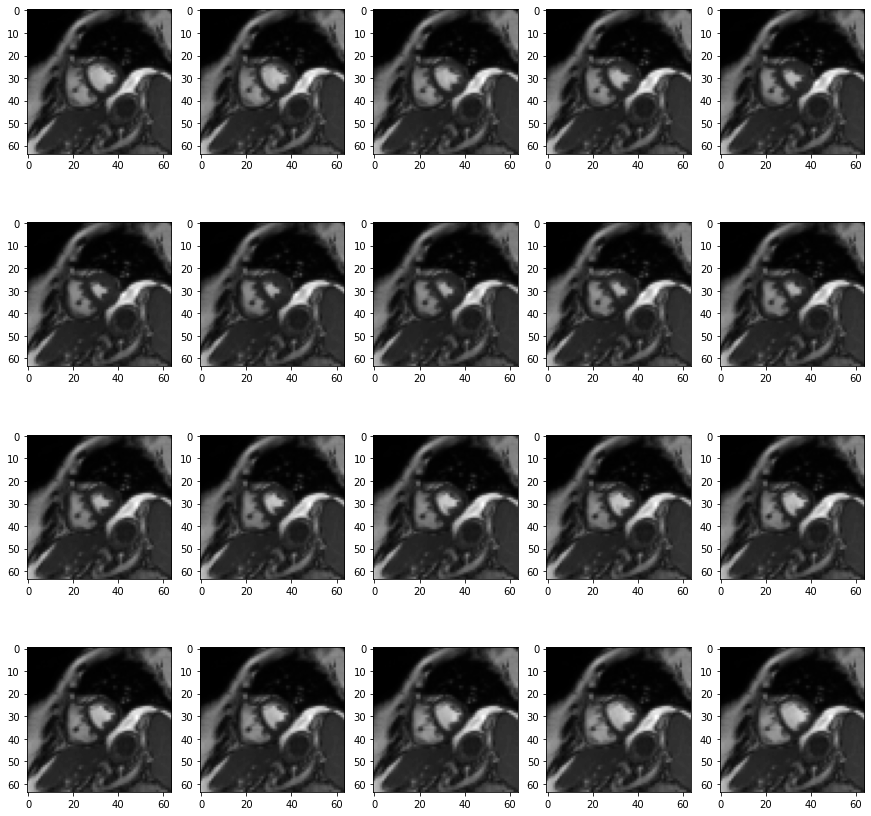

In [6]:
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(images[i][j-1], cmap="gray")

In [7]:
landmark_path = os.path.join(cfg.DATASET.ROOT, base_dir, cfg.DATASET.LANDMARK_FILE)
landmark_df = pd.read_csv(landmark_path, index_col="Subject")  # read .csv file as dataframe
landmarks = landmark_df.iloc[:, :6].values
y = landmark_df["Group"].values
y[np.where(y != 0)] = 1 

/var/folders/2q/3djqmyrx3wqdgl5t340yz7zw0000gn/T/ipykernel_31976/3032264643.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  visualize.plot_multi_images(


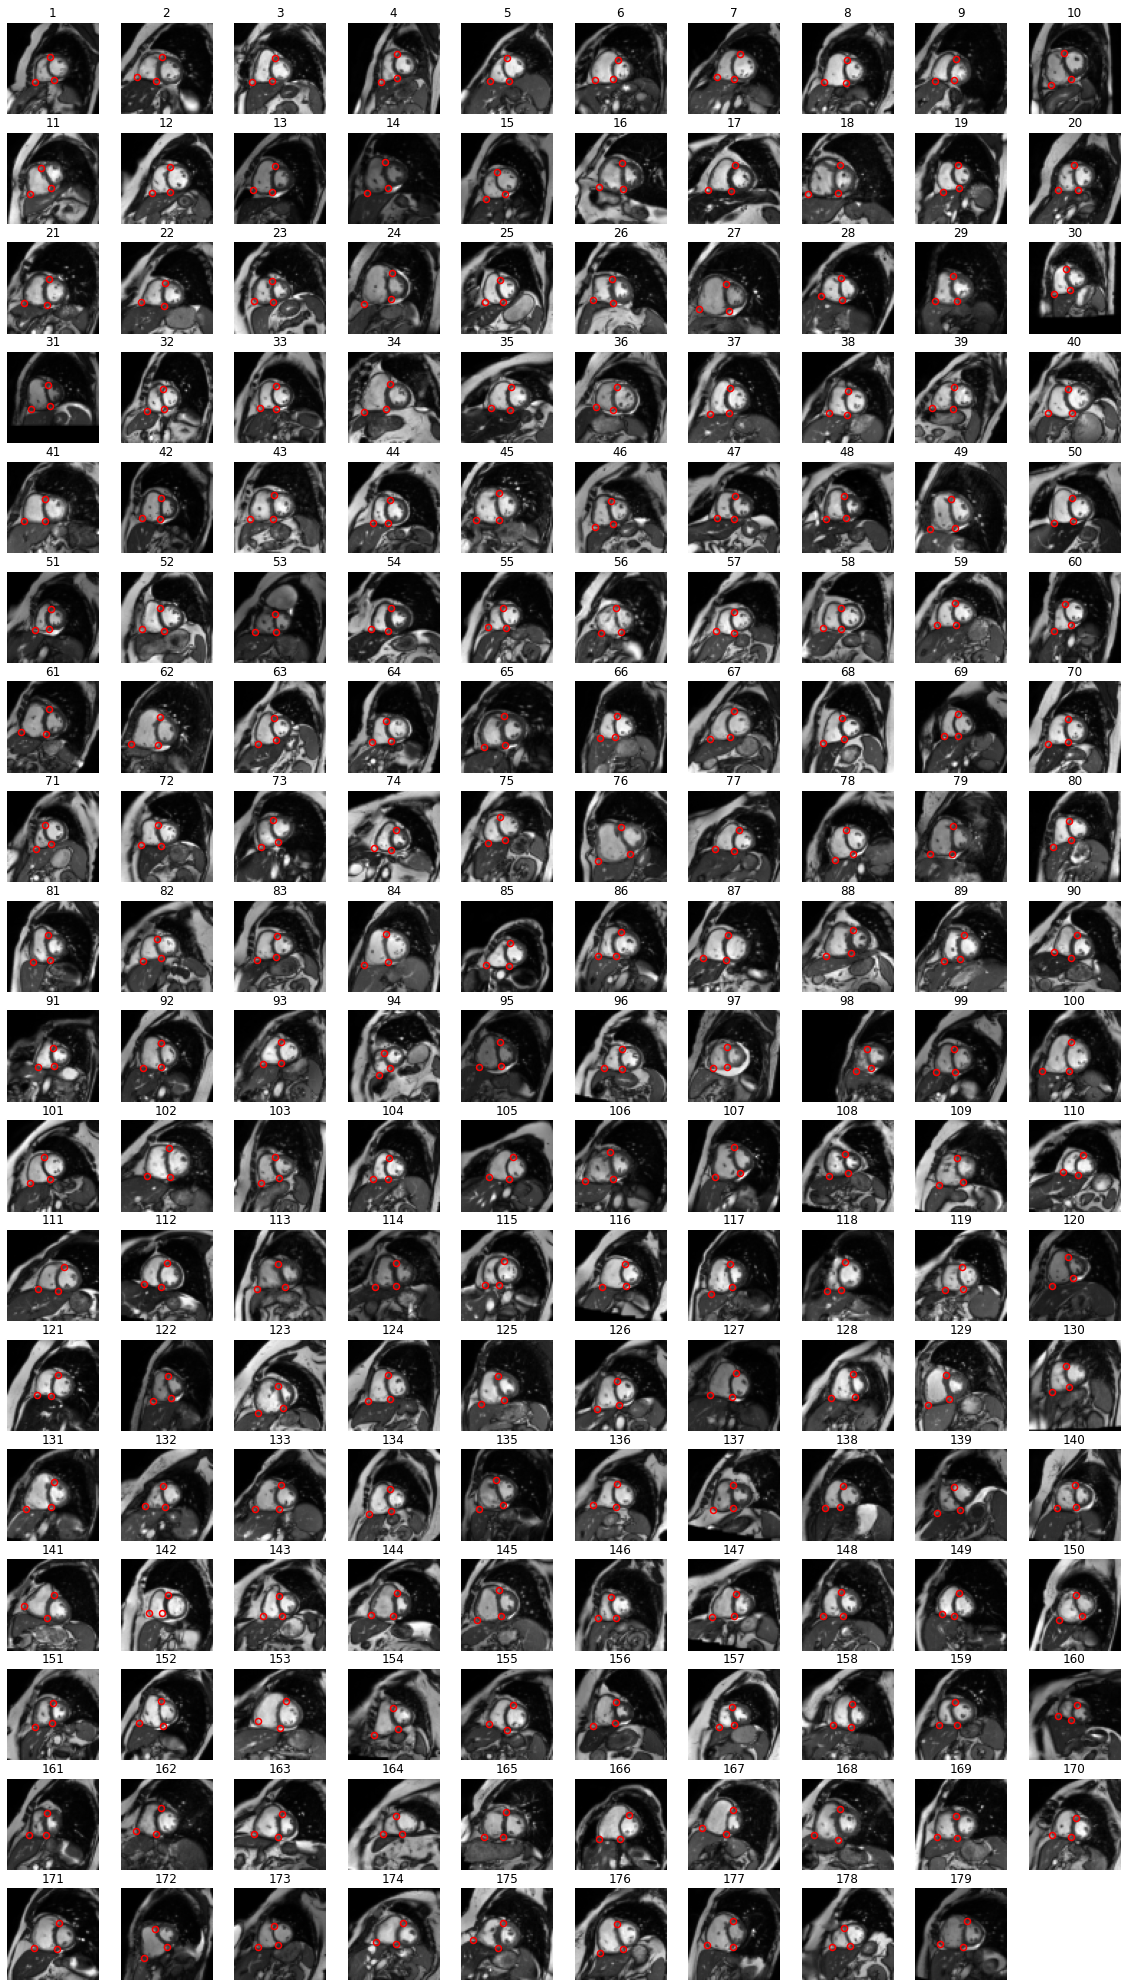

In [8]:
visualize.plot_multi_images(
    images[:, 0, ...], marker_locs=landmarks, im_kwargs=dict(cfg.IM_KWARGS), marker_kwargs=dict(cfg.MARKER_KWARGS)
).show()

In [9]:
from kale.prepdata.image_transform import mask_img_stack, normalize_img_stack, reg_img_stack, rescale_img_stack

In [10]:
img_reg, max_dist = reg_img_stack(images.copy(), landmarks)

In [11]:
img_masked = mask_img_stack(img_reg.copy(), mask[0, 0, ...])

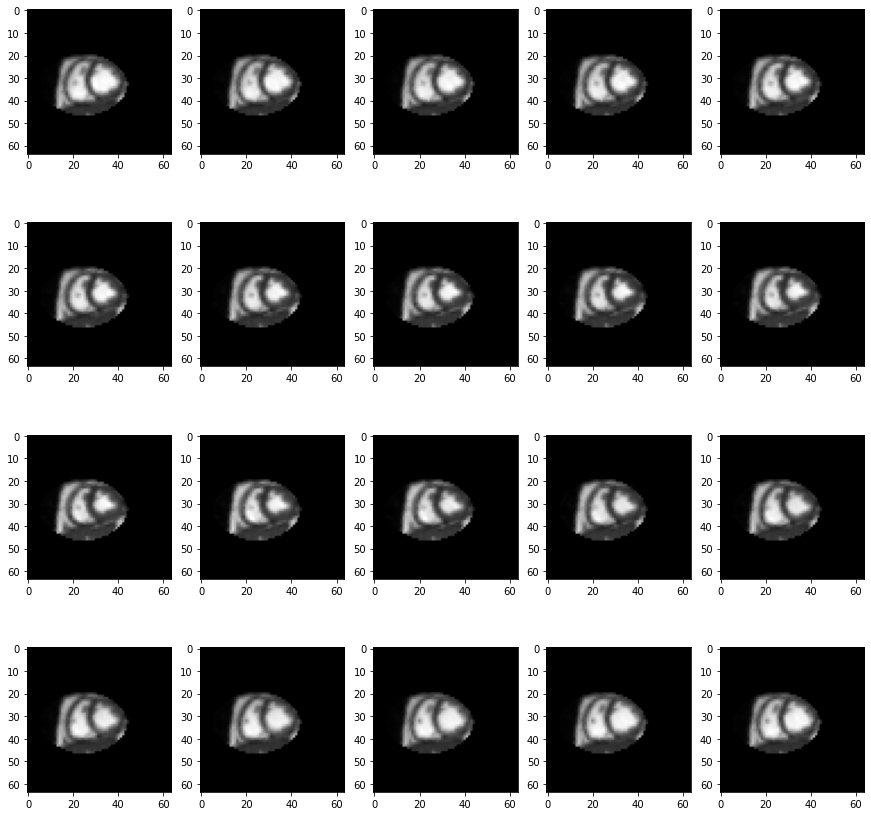

In [12]:
#Plotting masked images
i = random.randint(0, 178)

fig = plt.figure(figsize=(15,15))
for j in range(1,21):
    fig.add_subplot(4,5, j)
    plt.imshow(img_masked[i][j-1], cmap="gray")

In [13]:
img_rescaled = rescale_img_stack(img_masked.copy(), scale=1 / 2)

In [14]:
img_norm = normalize_img_stack(img_rescaled.copy())

In [15]:
x = img_norm.copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [17]:
import torchvision.transforms as transforms
from PIL import Image
import cv2

In [18]:
!pip install albumentations
import albumentations as A

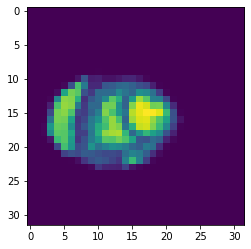

In [19]:
plt.imshow(x[0][0])
plt.show()

In [565]:
avg_acc = []
avg_ece = []
avg_log_loss = []

aug_avg_acc = []
aug_avg_ece = []
aug_avg_log_loss = []

combined_aug_avg_acc = []
combined_aug_avg_ece = []
combined_aug_avg_log_loss = []

# Physical Transformation

In [273]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=409)

In [274]:
transform = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.9),
        A.VerticalFlip(p=0.9),
    ]
)

In [275]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [276]:
augmented_images.shape, len(labels)

((50, 20, 32, 32), 50)

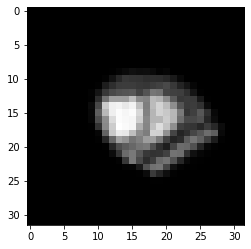

In [277]:
fig = plt.figure()
plt.imshow(augmented_images[8][9], cmap="gray")
plt.show()
#fig.savefig("Rotated CMRI image.jpg", bbox_inches='tight')

In [278]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

In [279]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [280]:
#for j in range(augmented_images.shape[0]):
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [281]:
model = MPCATrainer(classifier='lr', n_features=200)
aug_model = MPCATrainer(classifier='lr', n_features=200)
#calibrated_model.clf = CalibratedClassifierCV(calibrated_model.clf, cv=10, method='sigmoid')

In [282]:
model.fit(X_train, y_train)
aug_model.fit(X_train_aug, y_train_aug)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [283]:
y_hat = model.predict(X_test)
y_hat_aug = aug_model.predict(X_test)

In [284]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_aug_0 = aug_model.predict_proba(X_test)[:, 0]
y_probs_aug_1 = aug_model.predict_proba(X_test)[:, 1]

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


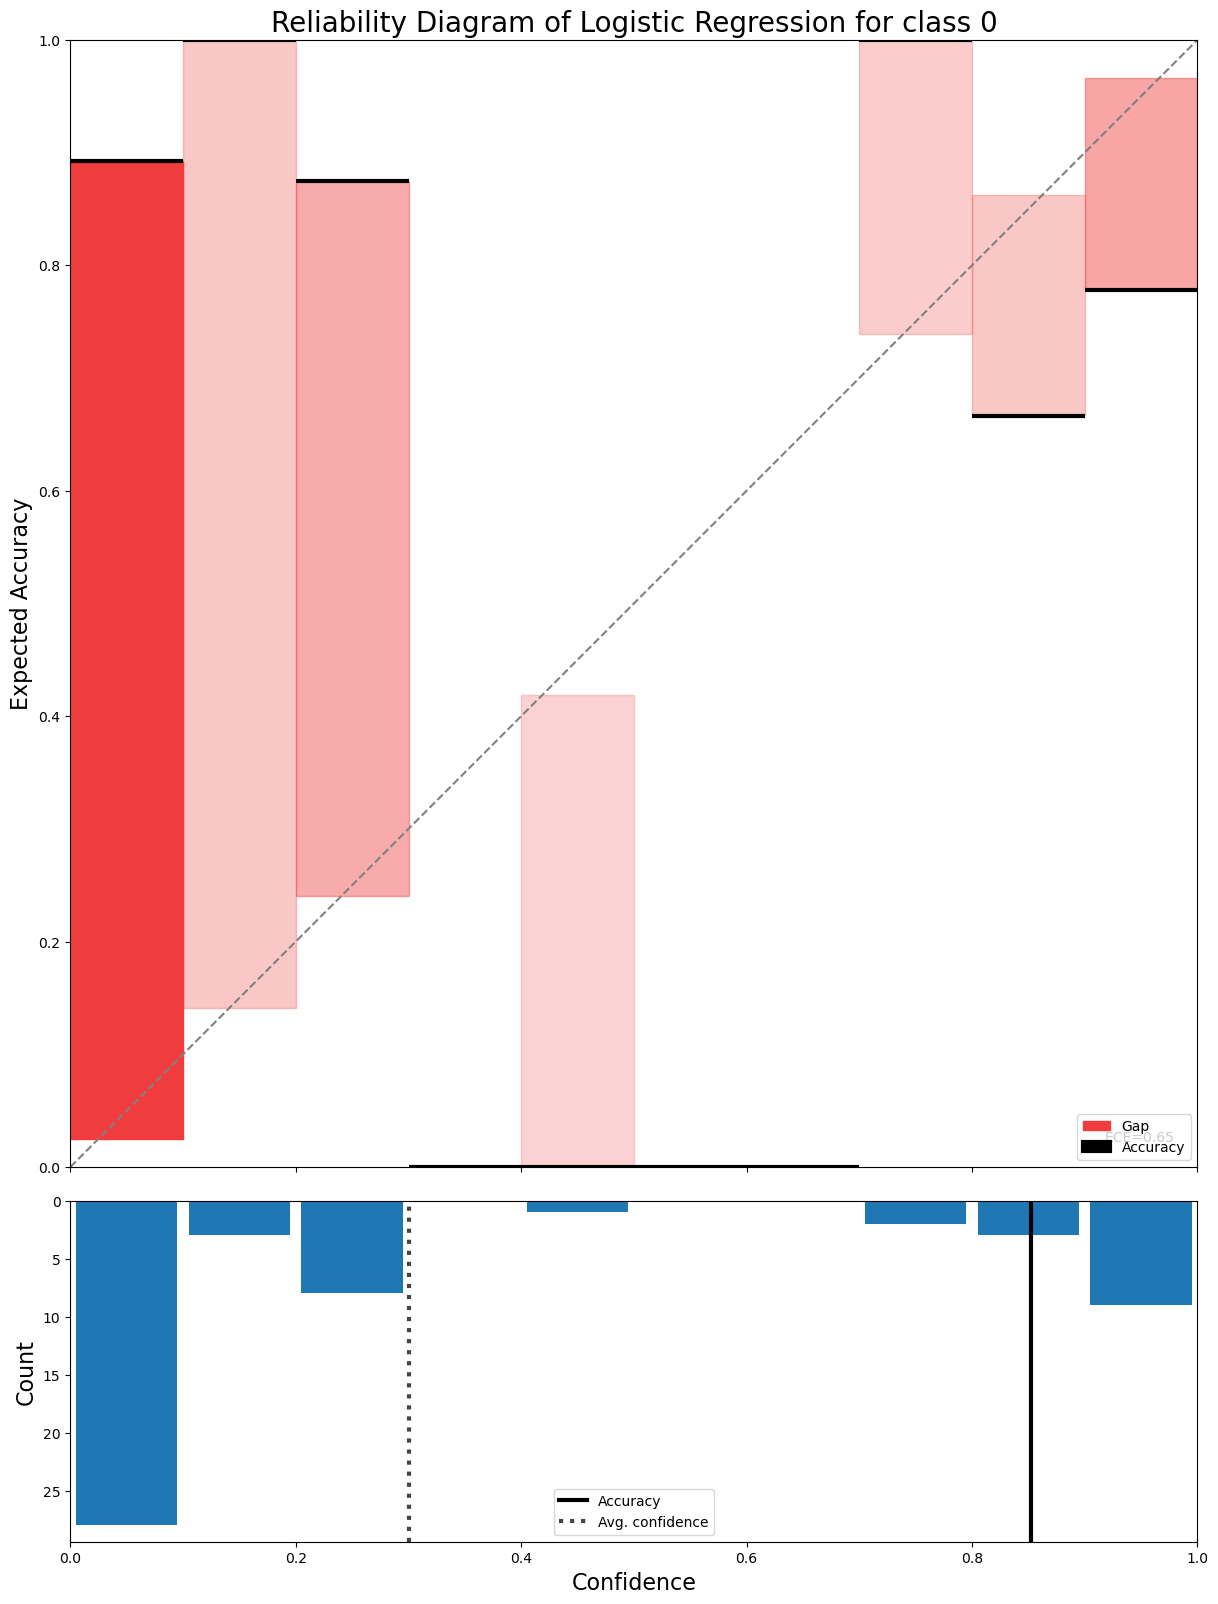

In [285]:
fig = reliability_diagram(y_test, y_hat, y_probs_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Logistic Regression for class 0.jpg", bbox_inches='tight')

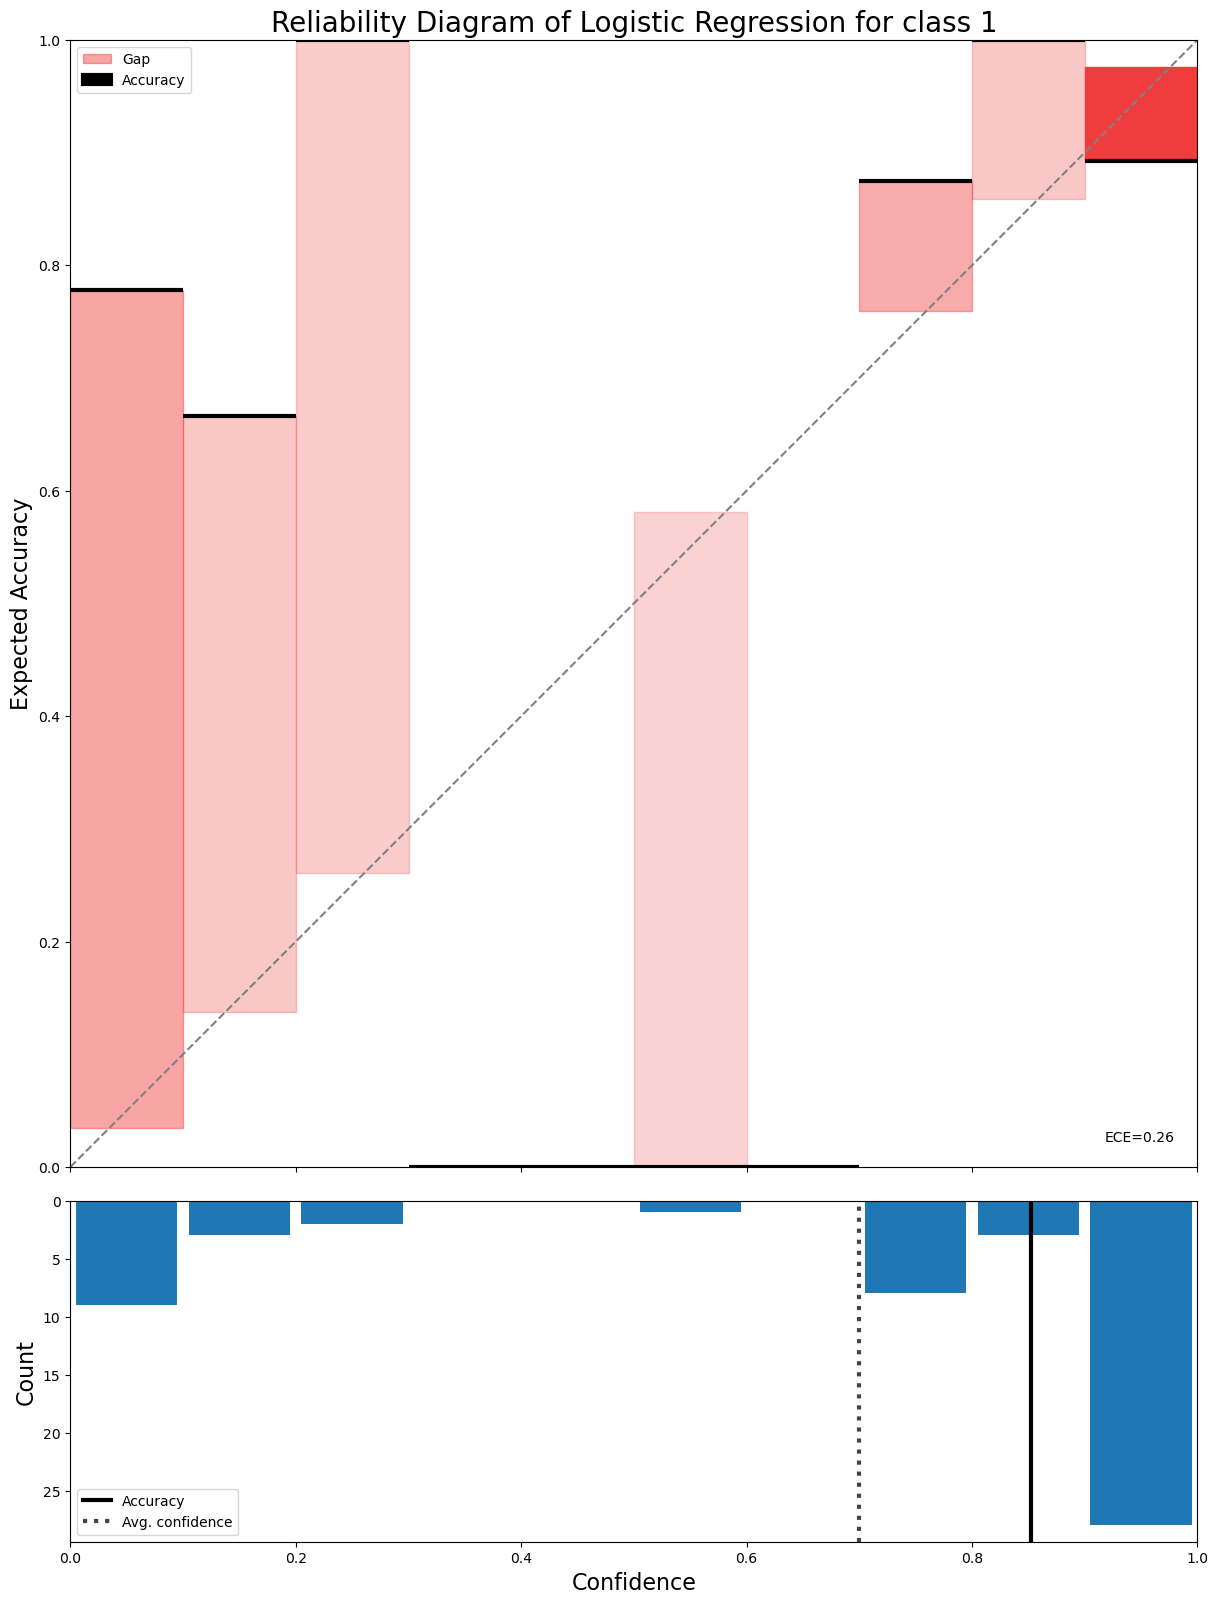

In [286]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Logistic Regression for class 1.jpg", bbox_inches='tight')

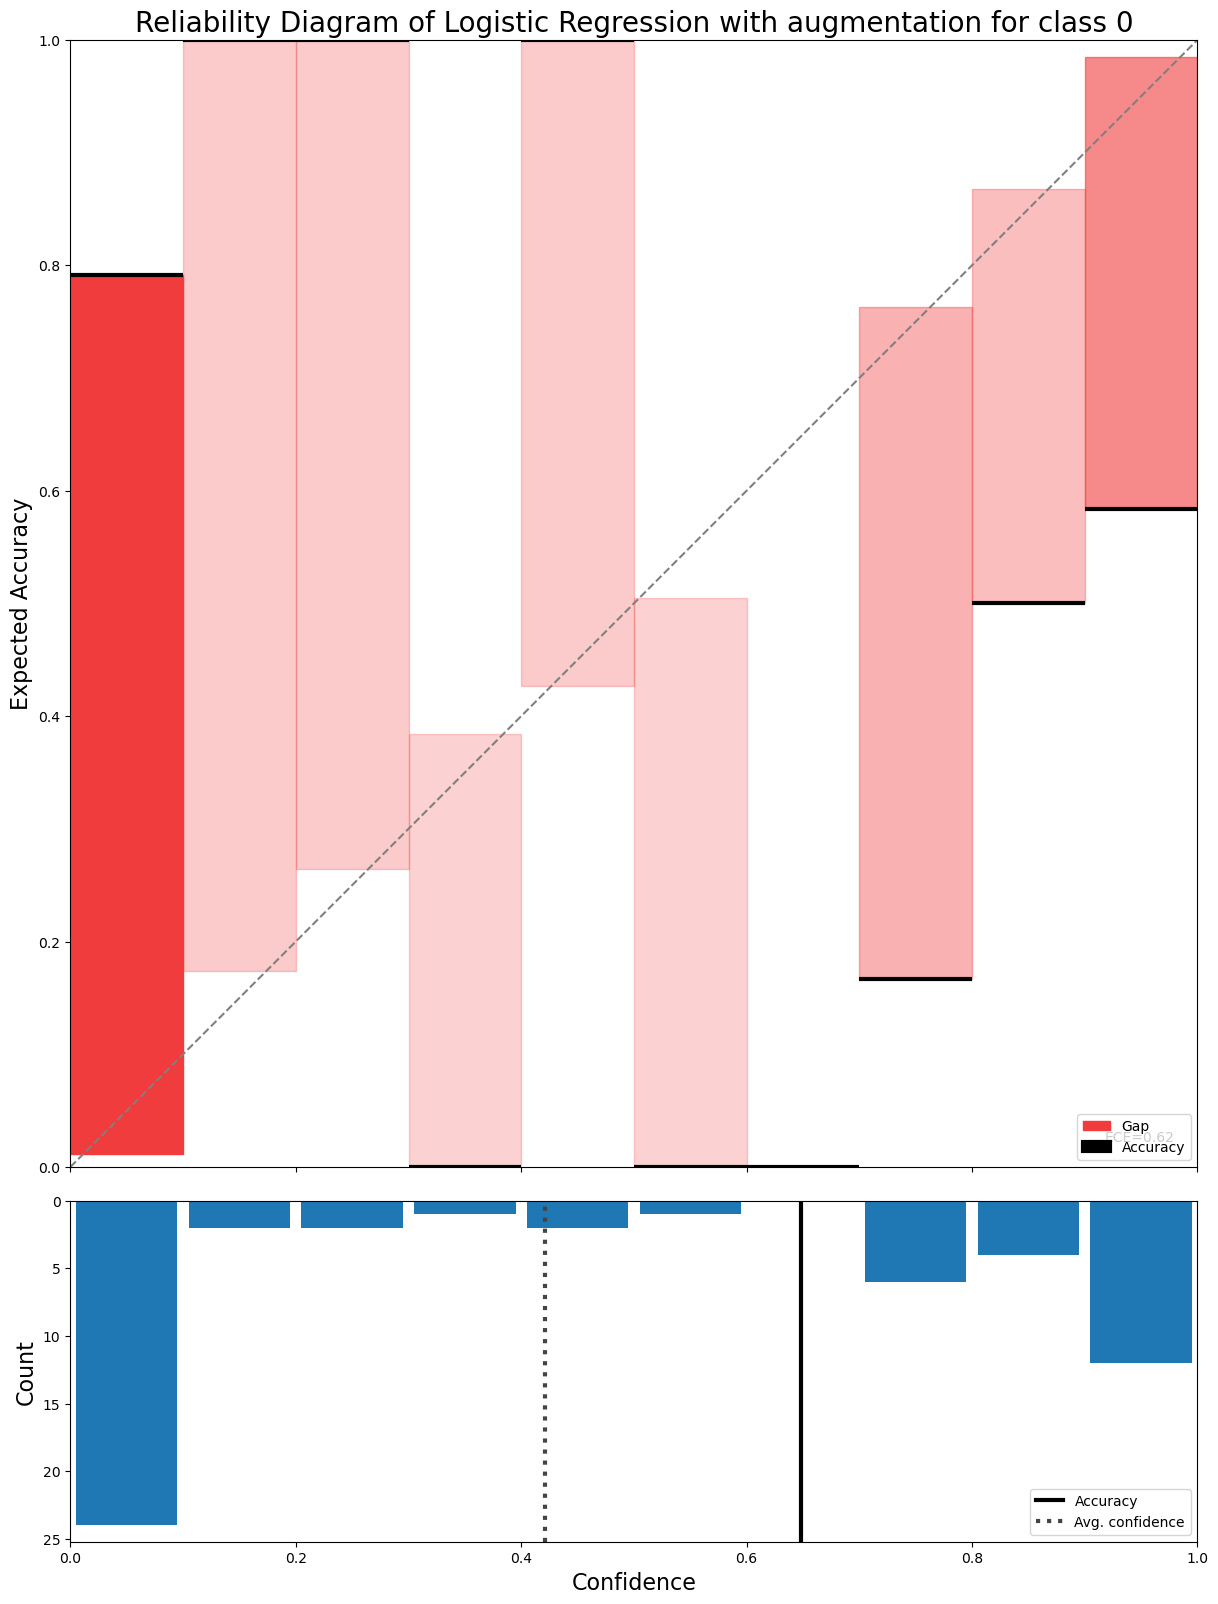

In [287]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression with augmentation for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Logistic Regression with augmentation for class 0.jpg", bbox_inches='tight')

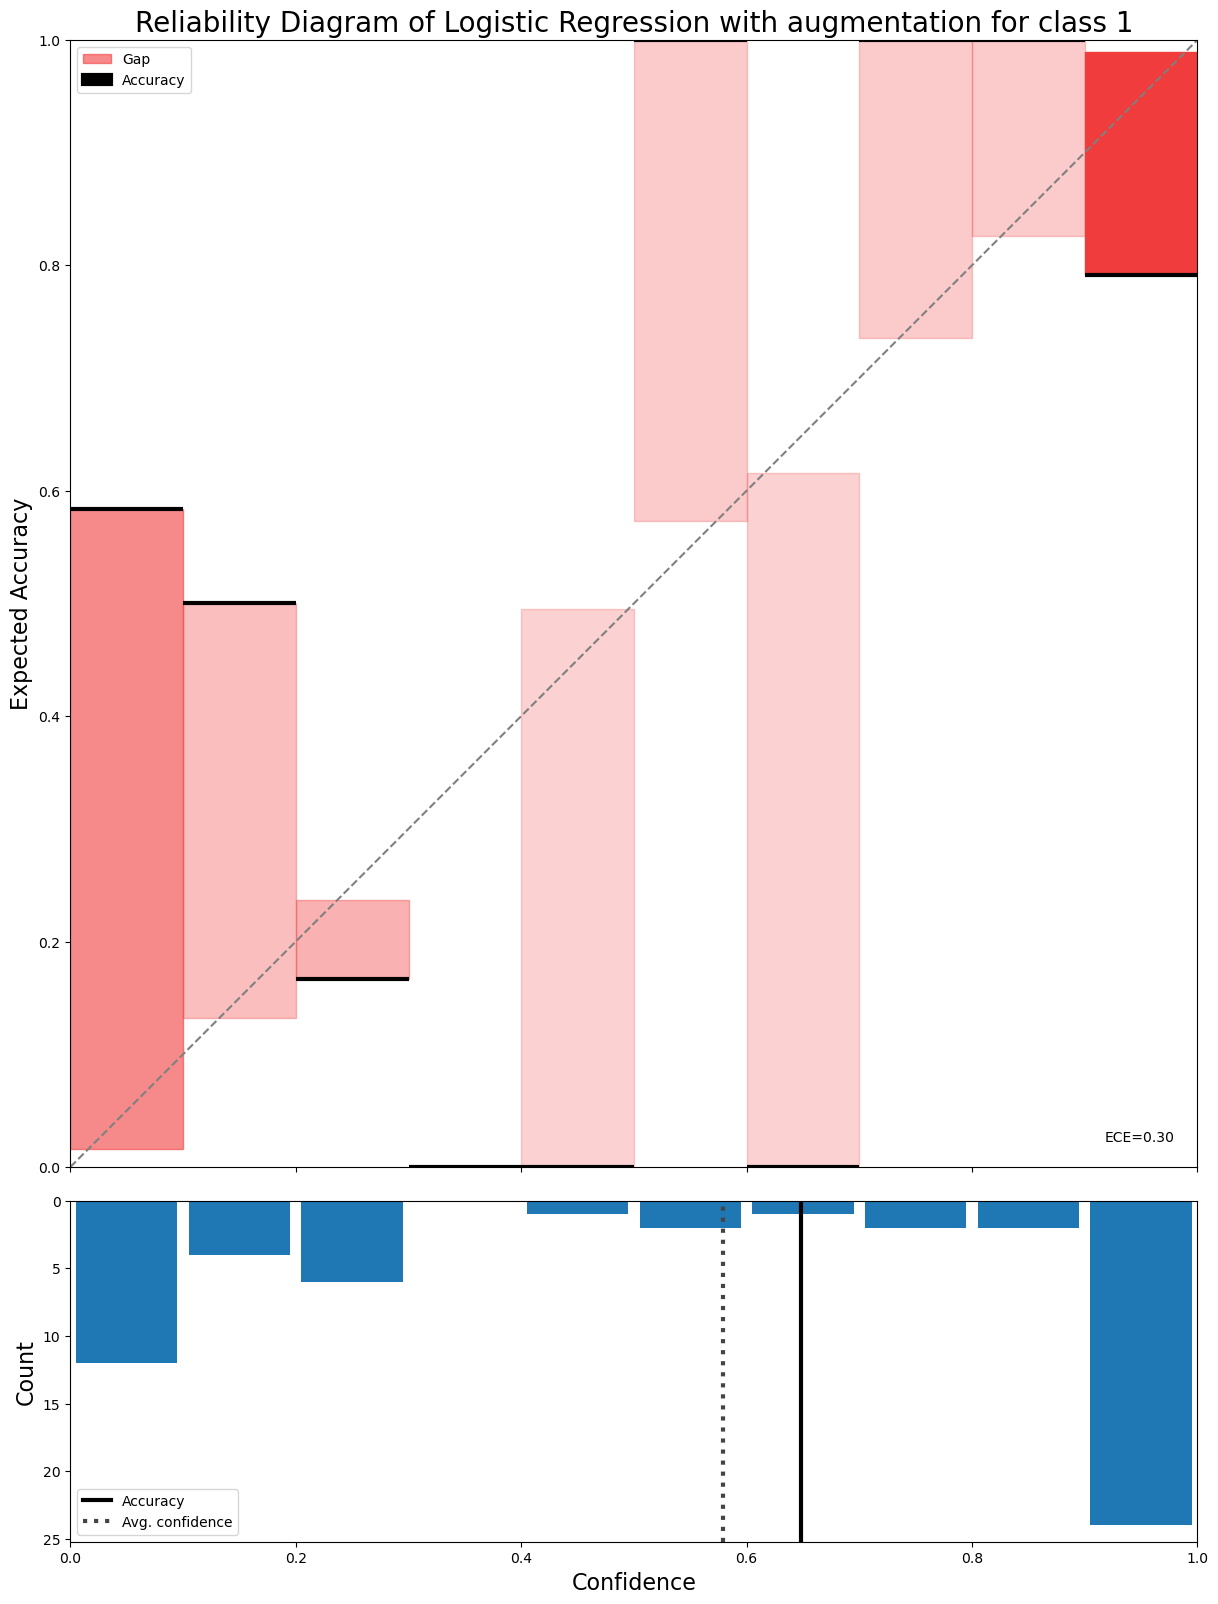

In [288]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression with augmentation for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of Logistic Regression with augmentation for class 1.jpg", bbox_inches='tight')

In [289]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.89285714, 1.        , 0.875     , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.66666667, 0.77777778]),
 'confidences': array([0.02439775, 0.14131691, 0.24047046, 0.        , 0.4189684 ,
        0.        , 0.        , 0.73939027, 0.86213601, 0.96580752]),
 'counts': array([28,  3,  8,  0,  1,  0,  0,  2,  3,  9]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.3001347430178281,
 'expected_calibration_error': 0.6516298547099417,
 'max_calibration_error': 0.868459392759501}

In [290]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.77777778, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.875     , 1.        , 0.89285714]),
 'confidences': array([0.03419248, 0.13786399, 0.26060973, 0.        , 0.        ,
        0.5810316 , 0.        , 0.75952954, 0.85868309, 0.97560225]),
 'counts': array([ 9,  3,  2,  0,  0,  1,  0,  8,  3, 28]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.6998652569821717,
 'expected_calibration_error': 0.25931602435247403,
 'max_calibration_error': 0.7435852995841218}

In [291]:
aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug, y_probs_aug_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.89285714, 1.        , 0.875     , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.66666667, 0.77777778]),
 'confidences': array([0.02439775, 0.14131691, 0.24047046, 0.        , 0.4189684 ,
        0.        , 0.        , 0.73939027, 0.86213601, 0.96580752]),
 'counts': array([28,  3,  8,  0,  1,  0,  0,  2,  3,  9]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.3001347430178281,
 'expected_calibration_error': 0.6516298547099417,
 'max_calibration_error': 0.868459392759501}

In [292]:
aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug, y_probs_aug_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.77777778, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.875     , 1.        , 0.89285714]),
 'confidences': array([0.03419248, 0.13786399, 0.26060973, 0.        , 0.        ,
        0.5810316 , 0.        , 0.75952954, 0.85868309, 0.97560225]),
 'counts': array([ 9,  3,  2,  0,  0,  1,  0,  8,  3, 28]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.6998652569821717,
 'expected_calibration_error': 0.25931602435247403,
 'max_calibration_error': 0.7435852995841218}

In [293]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [294]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.4554729395312079, 1.7552470228240238, 0.8518518518518519)

In [295]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

In [296]:
aug_log_loss_class_0 = log_loss(y_test, y_probs_aug_0)
aug_log_loss_class_1 = log_loss(y_test, y_probs_aug_1)
aug_avrg_log_loss = (aug_log_loss_class_0 + aug_log_loss_class_1)/2

aug_ece_class_0 = aug_calibration_scores_class_0["expected_calibration_error"]
aug_ece_class_1 = aug_calibration_scores_class_1["expected_calibration_error"]
aug_avrg_ece = (aug_ece_class_0 + aug_ece_class_1)/2

In [297]:
aug_avrg_ece, aug_avrg_log_loss, aug_calibration_scores_class_0["avg_accuracy"]

(0.46323873046347924, 2.373445980467299, 0.6481481481481481)

In [298]:
aug_avg_ece.append(aug_avrg_ece)
aug_avg_log_loss.append(aug_avrg_log_loss)
aug_avg_acc.append(aug_calibration_scores_class_0["avg_accuracy"])

In [299]:
# Think aout how exactly should you design this data augmentation experiments.

In [300]:
len(avg_ece)

10

In [301]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.014540269385244093, 0.28676591890313124, 0.013159880003288795)

In [302]:
np.std(aug_avg_ece)/np.sqrt(len(aug_avg_ece)), np.std(aug_avg_log_loss)/np.sqrt(len(aug_avg_log_loss)), np.std(aug_avg_acc)/np.sqrt(len(aug_avg_acc)) # calculating standard errors

(0.020479184337893808, 0.2926002096895379, 0.012627946015727644)

In [303]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.386218978569843, 1.5863639548679878, 0.7685185185185186)

In [304]:
np.mean(aug_avg_ece), np.mean(aug_avg_log_loss), np.mean(aug_avg_acc)# calculating standard errors

(0.37888144158938186, 1.7135261113777045, 0.7314814814814814)

# Colour Transformation

In [568]:
x = x.astype(np.float32)

In [836]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=409)

In [837]:
transform_colors = A.Compose(
    [
        A.RandomGamma(gamma_limit=(20, 180), always_apply=False, p=0.7),
        A.ColorJitter(p=0.6, brightness=0.3, hue=0.25, saturation=0.3, contrast=0.2)
    ]
)

In [838]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform_colors(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [839]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

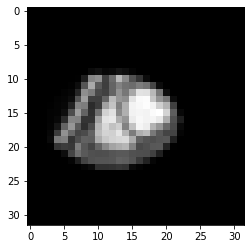

In [840]:
fig = plt.figure()
plt.imshow(augmented_images[8][3], cmap="gray")
plt.show()
fig.savefig("Color transformed CMRI image.jpg", bbox_inches='tight')

In [841]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [842]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [843]:
X_train_aug.shape

(175, 20, 32, 32)

In [844]:
model = MPCATrainer(classifier='lr', n_features=200)
aug_model = MPCATrainer(classifier='lr', n_features=200)

In [845]:
model.fit(X_train, y_train)
aug_model.fit(X_train_aug, y_train_aug)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [846]:
y_hat = model.predict(X_test)
y_hat_aug = aug_model.predict(X_test)

In [847]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_aug_0 = aug_model.predict_proba(X_test)[:, 0]
y_probs_aug_1 = aug_model.predict_proba(X_test)[:, 1]

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


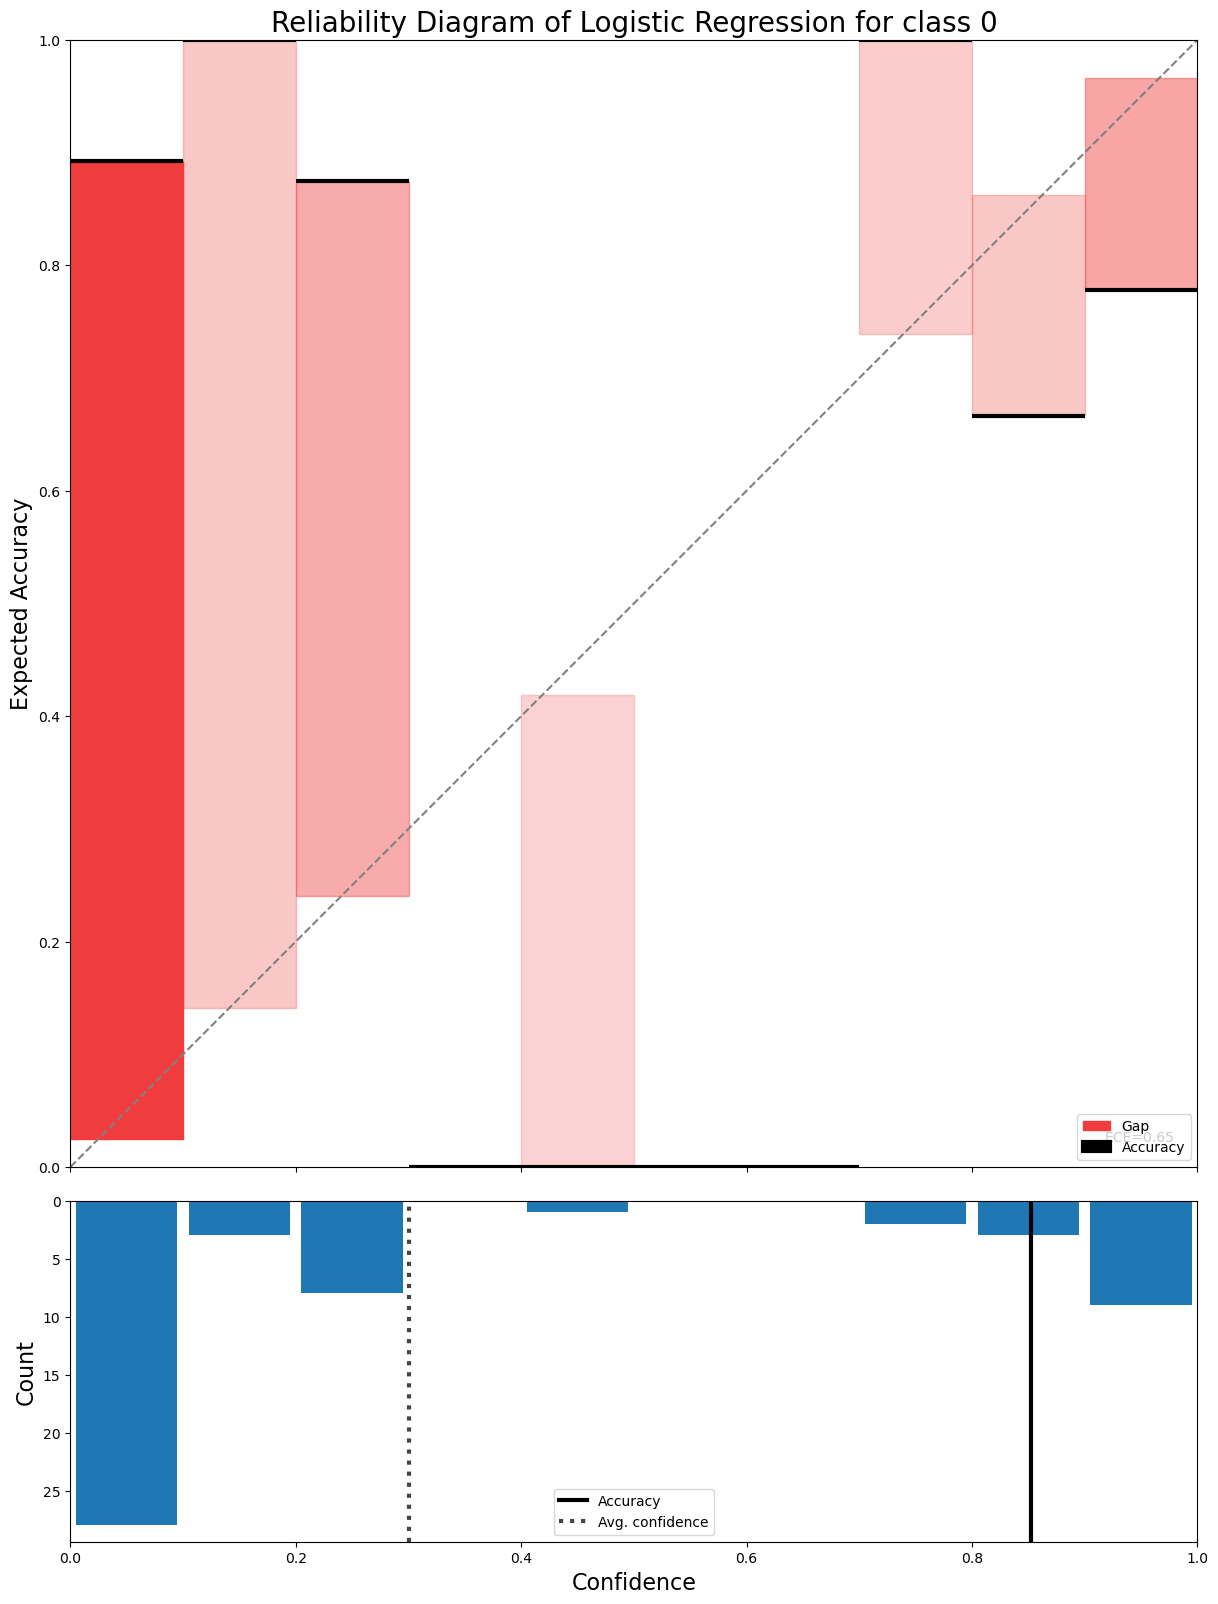

In [848]:
fig = reliability_diagram(y_test, y_hat, y_probs_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

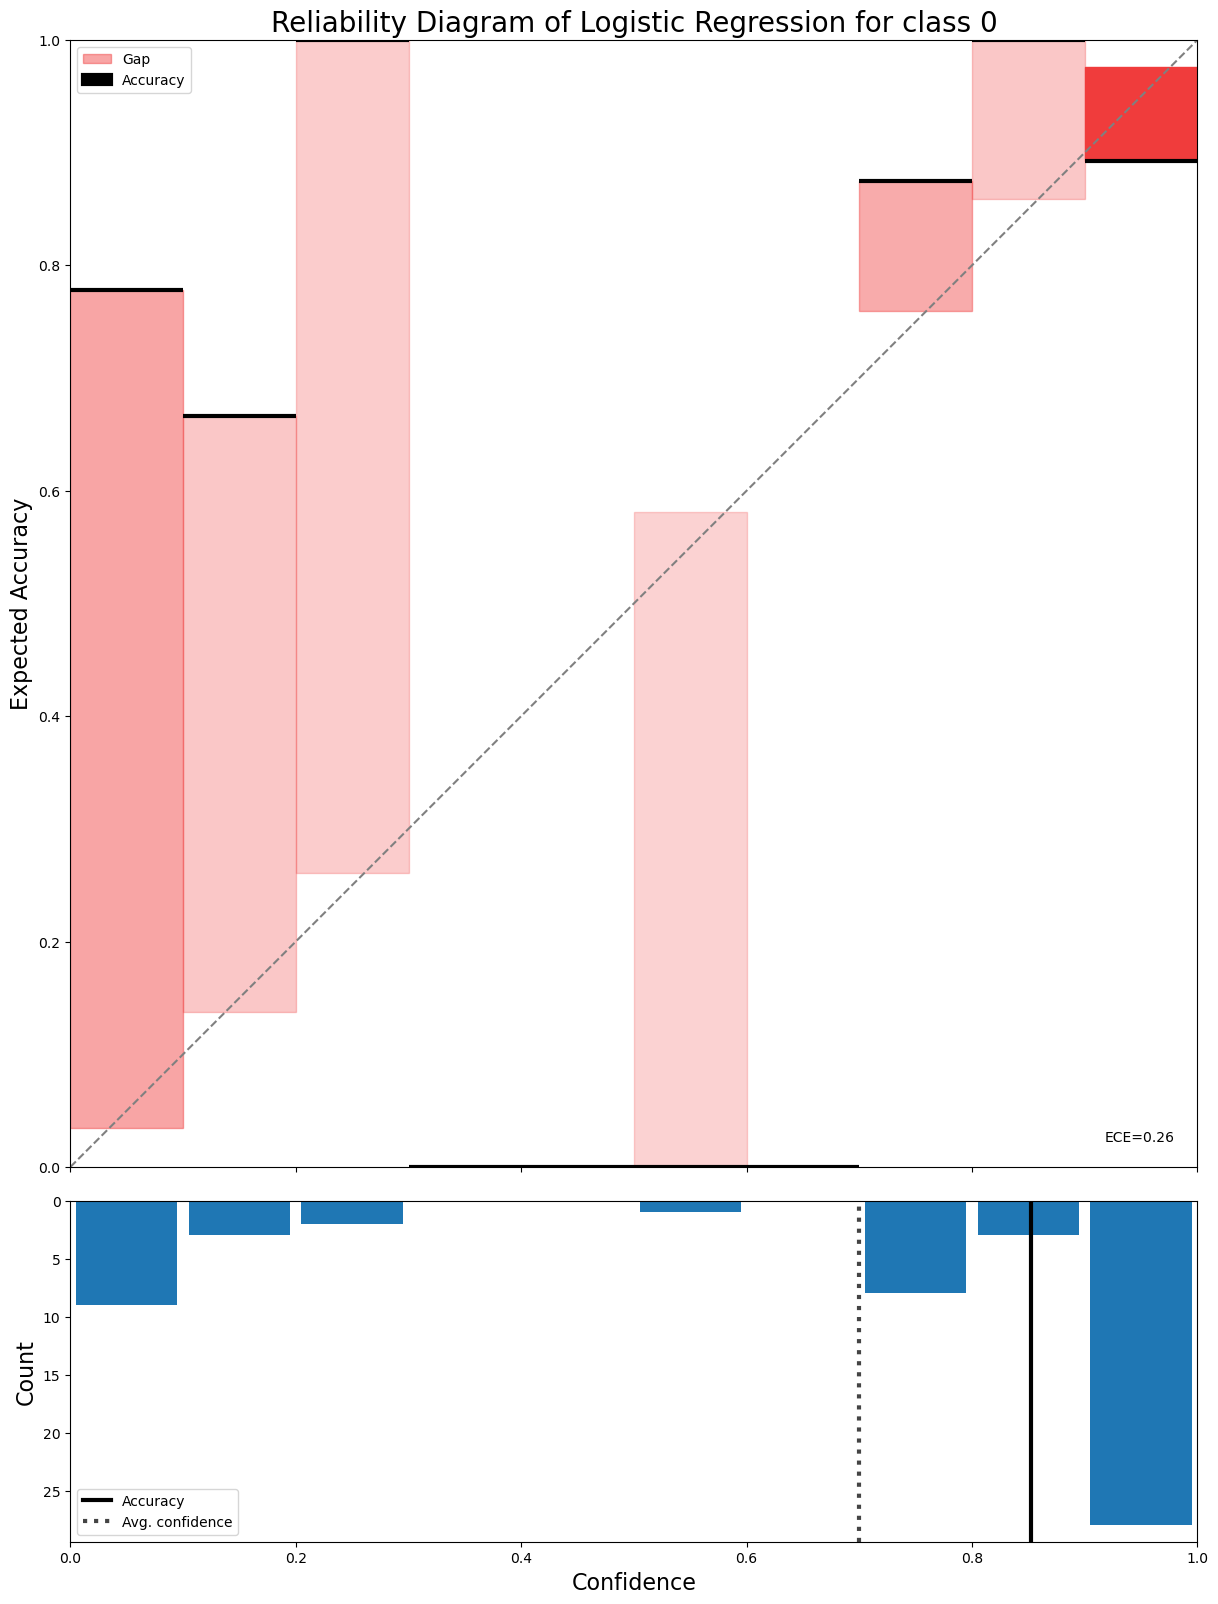

In [849]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

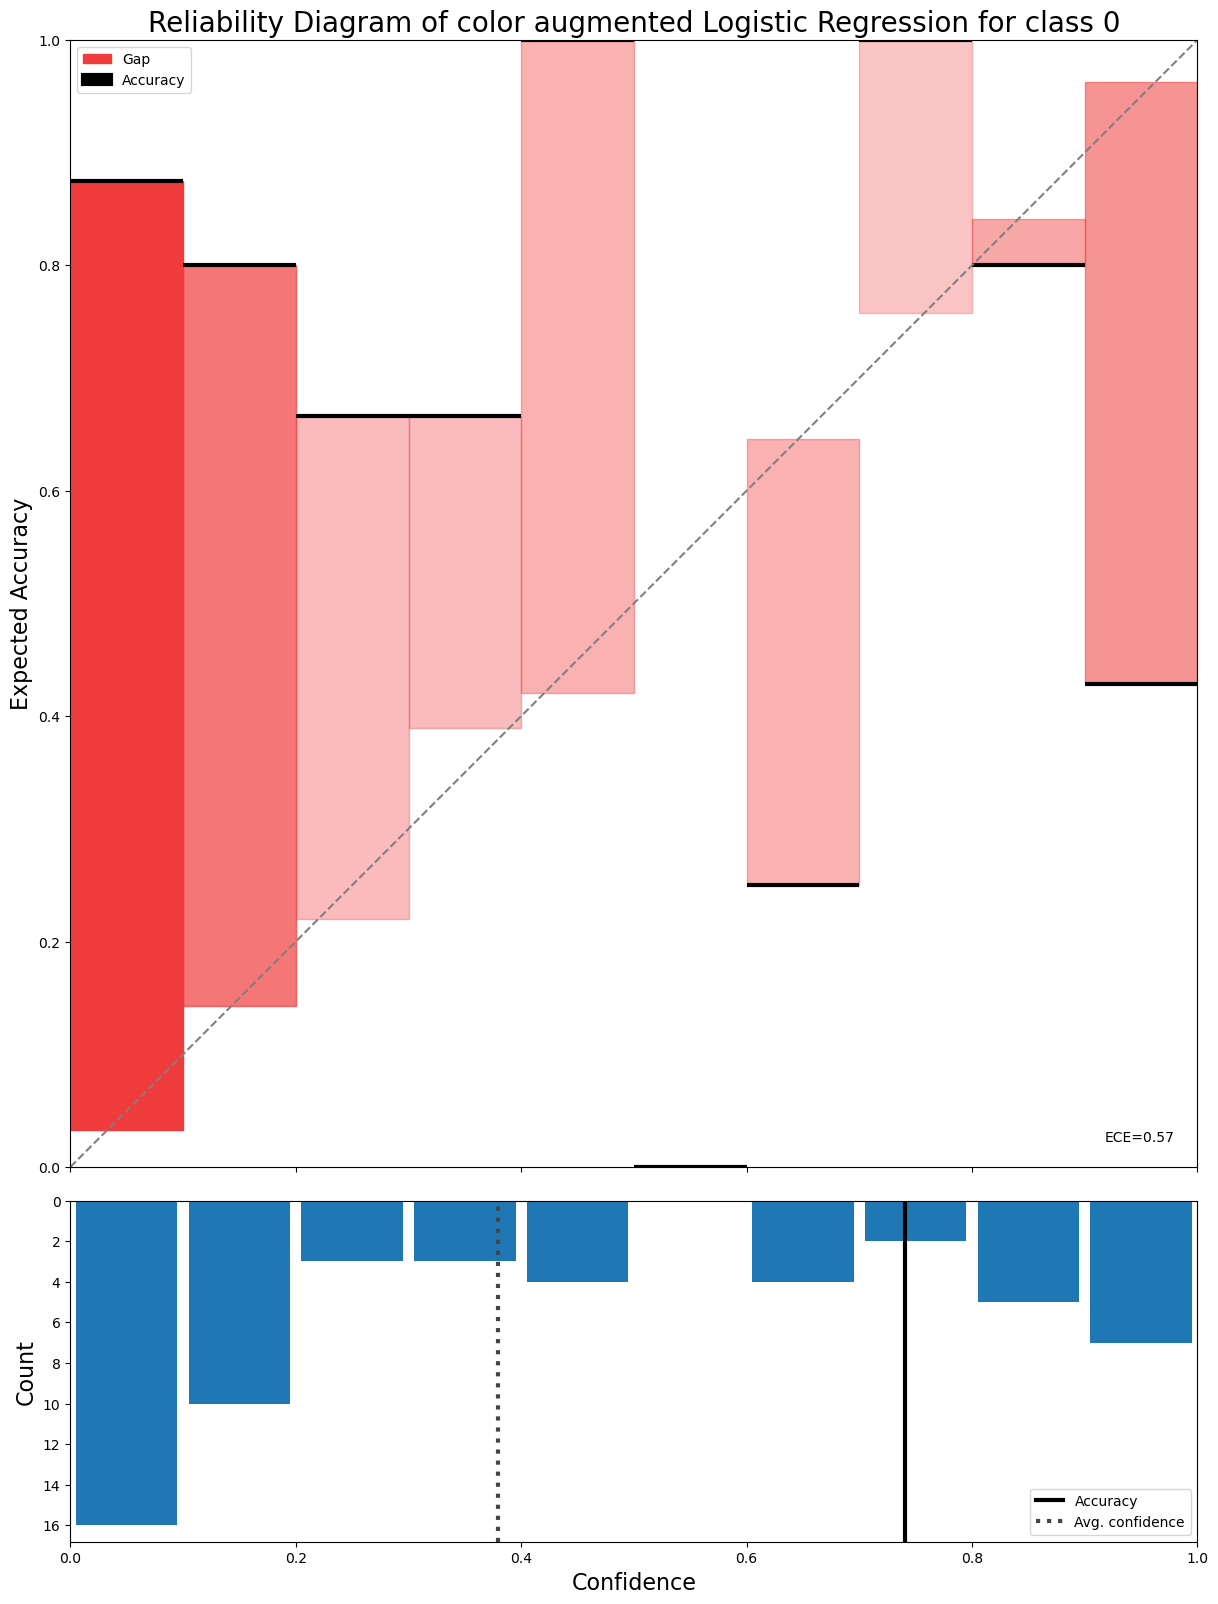

In [850]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of color augmented Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)

fig.savefig("Reliability Diagram of Logistic Regression with color augmentation for class 0.jpg", bbox_inches='tight')

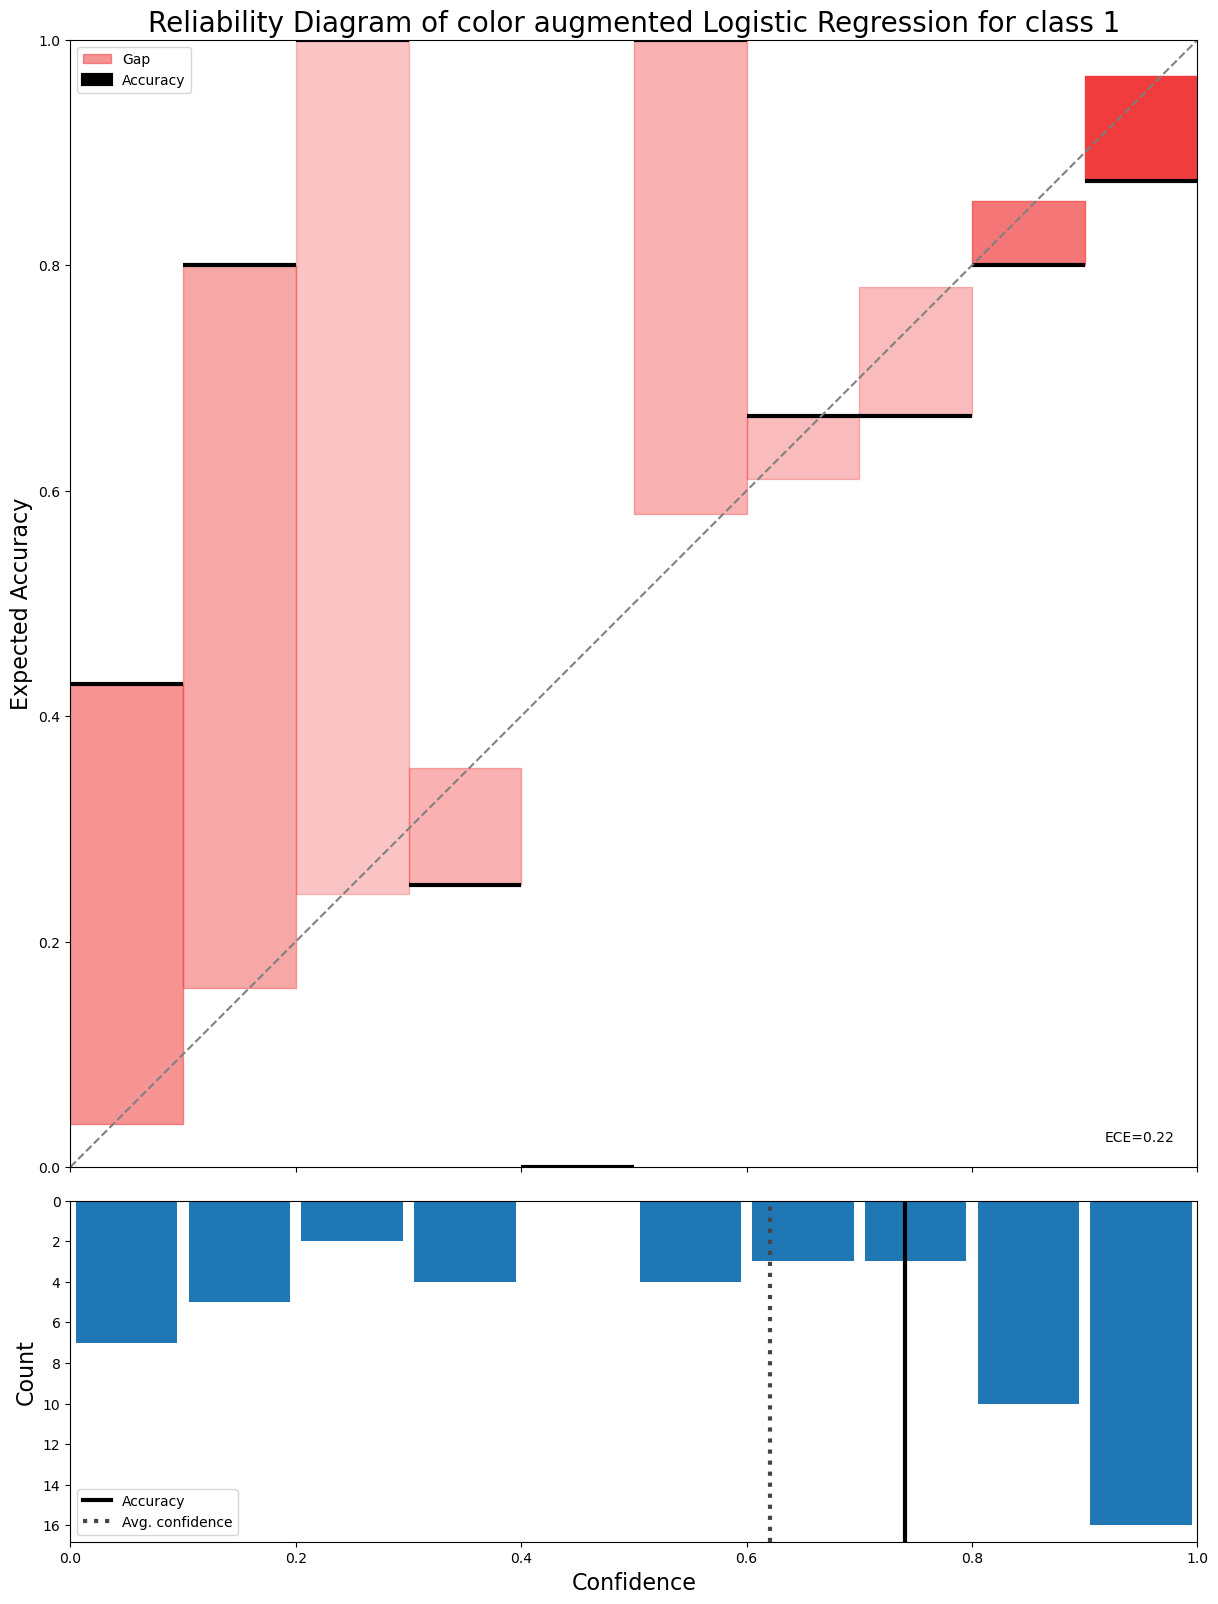

In [851]:
fig = reliability_diagram(y_test, y_hat_aug, y_probs_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of color augmented Logistic Regression for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)

fig.savefig("Reliability Diagram of Logistic Regression with color augmentation for class 1.jpg", bbox_inches='tight')

In [852]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.89285714, 1.        , 0.875     , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.66666667, 0.77777778]),
 'confidences': array([0.0243985 , 0.14131353, 0.24047783, 0.        , 0.41897625,
        0.        , 0.        , 0.73940313, 0.86213739, 0.96580605]),
 'counts': array([28,  3,  8,  0,  1,  0,  0,  2,  3,  9]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.30013648763686446,
 'expected_calibration_error': 0.6516280624783848,
 'max_calibration_error': 0.8684586444311218}

In [853]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.77777778, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.875     , 1.        , 0.89285714]),
 'confidences': array([0.03419395, 0.13786261, 0.26059687, 0.        , 0.        ,
        0.58102375, 0.        , 0.75952217, 0.85868647, 0.9756015 ]),
 'counts': array([ 9,  3,  2,  0,  0,  1,  0,  8,  3, 28]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.6998635123631357,
 'expected_calibration_error': 0.2593167022287122,
 'max_calibration_error': 0.7435838242624996}

In [854]:
aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug, y_probs_aug_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.89285714, 1.        , 0.875     , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.66666667, 0.77777778]),
 'confidences': array([0.0243985 , 0.14131353, 0.24047783, 0.        , 0.41897625,
        0.        , 0.        , 0.73940313, 0.86213739, 0.96580605]),
 'counts': array([28,  3,  8,  0,  1,  0,  0,  2,  3,  9]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.30013648763686446,
 'expected_calibration_error': 0.6516280624783848,
 'max_calibration_error': 0.8684586444311218}

In [855]:
aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug, y_probs_aug_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.77777778, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.875     , 1.        , 0.89285714]),
 'confidences': array([0.03419395, 0.13786261, 0.26059687, 0.        , 0.        ,
        0.58102375, 0.        , 0.75952217, 0.85868647, 0.9756015 ]),
 'counts': array([ 9,  3,  2,  0,  0,  1,  0,  8,  3, 28]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.6998635123631357,
 'expected_calibration_error': 0.2593167022287122,
 'max_calibration_error': 0.7435838242624996}

In [856]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [827]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.4611388898970715, 3.761987311338808, 0.7592592592592593)

In [828]:
aug_log_loss_class_0 = log_loss(y_test, y_probs_aug_0)
aug_log_loss_class_1 = log_loss(y_test, y_probs_aug_1)
aug_avrg_log_loss = (aug_log_loss_class_0 + aug_log_loss_class_1)/2

aug_ece_class_0 = aug_calibration_scores_class_0["expected_calibration_error"]
aug_ece_class_1 = aug_calibration_scores_class_1["expected_calibration_error"]
aug_avrg_ece = (aug_ece_class_0 + aug_ece_class_1)/2

In [829]:
aug_avrg_ece, aug_avrg_log_loss, aug_calibration_scores_class_0["avg_accuracy"]

(0.3433193917890934, 1.0982723984566294, 0.6481481481481481)

In [830]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

aug_avg_ece.append(aug_avrg_ece)
aug_avg_log_loss.append(aug_avrg_log_loss)
aug_avg_acc.append(aug_calibration_scores_class_0["avg_accuracy"])

In [831]:
len(aug_avg_acc)

10

In [832]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.014540017473311562, 0.28672711258342254, 0.013159880003288795)

In [833]:
np.std(aug_avg_ece)/np.sqrt(len(aug_avg_ece)), np.std(aug_avg_log_loss)/np.sqrt(len(aug_avg_log_loss)), np.std(aug_avg_acc)/np.sqrt(len(aug_avg_acc)) # calculating standard errors

(0.022325694207409014, 0.295546911250284, 0.013468960404420872)

In [834]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.38621842638838705, 1.5863105718186334, 0.7685185185185186)

In [835]:
np.mean(aug_avg_ece), np.mean(aug_avg_log_loss), np.mean(aug_avg_acc) # calculating standard errors

(0.36201450493458676, 1.616138924593951, 0.65)

# Combined Transformations

In [350]:
x = x.astype(np.float32)

In [540]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=409)

In [541]:
transform_combined = A.Compose(
    [
        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p=0.9),
        A.VerticalFlip(p=0.9),
        A.RandomGamma(gamma_limit=(20, 180), always_apply=False, p=0.7),
        A.ColorJitter(p=0.6, brightness=0.3, hue=0.25, saturation=0.3, contrast=0.2)
        
    ]
)

In [542]:
augmented_images = 0
img = []
labels = []
for k in range(50):
    idx = np.where(y==0)[0][k]
    image = X_train[idx][0]
    images_list = [image]
    label = y[idx]
    for i in range(19):
        augmentations = transform_combined(image=image)
        augmented_img = augmentations["image"]
        images_list.append(augmented_img)
    labels.append(label)
    img.append(images_list)
augmented_images = np.array(img)

In [543]:
y_aug = np.array(labels)
y_aug = y_aug.flatten()
y_aug.shape

(50,)

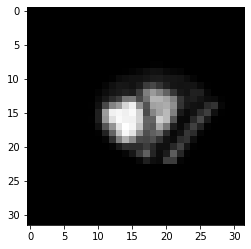

In [544]:
fig = plt.figure()
plt.imshow(augmented_images[8][8], cmap="gray")
plt.show()
fig.savefig("Combined transformation CMRI image.jpg", bbox_inches='tight')

In [545]:
y_train.reshape((y_train.shape[0], 1))
y_train.shape

(125,)

In [546]:
X_train_aug = np.concatenate((X_train, augmented_images), axis=0)
y_train_aug = np.concatenate((y_train, y_aug), axis=0)

In [547]:
model = MPCATrainer(classifier='lr', n_features=200)
combined_aug_model = MPCATrainer(classifier='lr', n_features=200)

In [548]:
model.fit(X_train, y_train)
combined_aug_model.fit(X_train_aug, y_train_aug)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [549]:
y_hat = model.predict(X_test)
y_hat_aug_combined = combined_aug_model.predict(X_test)

In [550]:
y_probs_0 = model.predict_proba(X_test)[:, 0]
y_probs_1 = model.predict_proba(X_test)[:, 1]
y_probs_combined_aug_0 = combined_aug_model.predict_proba(X_test)[:, 0]
y_probs_combined_aug_1 = combined_aug_model.predict_proba(X_test)[:, 1]

In [551]:
calibration_scores_class_0 = compute_calibration(y_test, y_hat, y_probs_0, num_bins=10)
calibration_scores_class_0

{'accuracies': array([0.89285714, 1.        , 0.875     , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.66666667, 0.77777778]),
 'confidences': array([0.0243985 , 0.14131353, 0.24047783, 0.        , 0.41897625,
        0.        , 0.        , 0.73940313, 0.86213739, 0.96580605]),
 'counts': array([28,  3,  8,  0,  1,  0,  0,  2,  3,  9]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.30013648763686446,
 'expected_calibration_error': 0.6516280624783848,
 'max_calibration_error': 0.8684586444311218}

In [552]:
calibration_scores_class_1 = compute_calibration(y_test, y_hat, y_probs_1, num_bins=10)
calibration_scores_class_1

{'accuracies': array([0.77777778, 0.66666667, 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.875     , 1.        , 0.89285714]),
 'confidences': array([0.03419395, 0.13786261, 0.26059687, 0.        , 0.        ,
        0.58102375, 0.        , 0.75952217, 0.85868647, 0.9756015 ]),
 'counts': array([ 9,  3,  2,  0,  0,  1,  0,  8,  3, 28]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.8518518518518519,
 'avg_confidence': 0.6998635123631357,
 'expected_calibration_error': 0.2593167022287122,
 'max_calibration_error': 0.7435838242624996}

In [553]:
combined_aug_calibration_scores_class_0 = compute_calibration(y_test, y_hat_aug_combined, y_probs_combined_aug_0, num_bins=10)
combined_aug_calibration_scores_class_0

{'accuracies': array([0.81818182, 1.        , 0.5       , 1.        , 0.5       ,
        0.33333333, 0.5       , 0.5       , 0.33333333, 0.71428571]),
 'confidences': array([0.03223384, 0.13537978, 0.2344567 , 0.36971256, 0.46673721,
        0.54963925, 0.64522234, 0.76719444, 0.85534152, 0.95788806]),
 'counts': array([22,  5,  2,  4,  2,  3,  2,  4,  3,  7]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7222222222222222,
 'avg_confidence': 0.3619752318433399,
 'expected_calibration_error': 0.5557796251091628,
 'max_calibration_error': 0.8646202212800778}

In [554]:
combined_aug_calibration_scores_class_1 = compute_calibration(y_test, y_hat_aug_combined, y_probs_combined_aug_1, num_bins=10)
combined_aug_calibration_scores_class_1

{'accuracies': array([0.71428571, 0.33333333, 0.5       , 0.5       , 0.33333333,
        0.5       , 1.        , 0.5       , 1.        , 0.81818182]),
 'confidences': array([0.04211194, 0.14465848, 0.23280556, 0.35477766, 0.45036075,
        0.53326279, 0.63028744, 0.7655433 , 0.86462022, 0.96776616]),
 'counts': array([ 7,  3,  4,  2,  3,  2,  4,  2,  5, 22]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.7222222222222222,
 'avg_confidence': 0.6380247681566601,
 'expected_calibration_error': 0.24121782418081922,
 'max_calibration_error': 0.6721737740925732}

In [555]:
log_loss_class_0 = log_loss(y_test, y_probs_0)
log_loss_class_1 = log_loss(y_test, y_probs_1)
avrg_log_loss = (log_loss_class_0 + log_loss_class_1)/2

ece_class_0 = calibration_scores_class_0["expected_calibration_error"]
ece_class_1 = calibration_scores_class_1["expected_calibration_error"]
avrg_ece = (ece_class_0 + ece_class_1)/2

In [556]:
avrg_ece, avrg_log_loss, calibration_scores_class_0["avg_accuracy"]

(0.4554723823535485, 1.7552397733089367, 0.8518518518518519)

In [557]:
combined_aug_log_loss_class_0 = log_loss(y_test, y_probs_combined_aug_0)
combined_aug_log_loss_class_1 = log_loss(y_test, y_probs_combined_aug_1)
combined_aug_avrg_log_loss = (combined_aug_log_loss_class_0 + combined_aug_log_loss_class_1)/2

combined_aug_ece_class_0 = combined_aug_calibration_scores_class_0["expected_calibration_error"]
combined_aug_ece_class_1 = combined_aug_calibration_scores_class_1["expected_calibration_error"]
combined_aug_avrg_ece = (combined_aug_ece_class_0 + combined_aug_ece_class_1)/2

In [558]:
combined_aug_avrg_ece, combined_aug_avrg_log_loss, combined_aug_calibration_scores_class_0["avg_accuracy"]

(0.39849872464499103, 1.4378188496959254, 0.7222222222222222)

In [559]:
avg_ece.append(avrg_ece)
avg_log_loss.append(avrg_log_loss)
avg_acc.append(calibration_scores_class_0["avg_accuracy"])

combined_aug_avg_ece.append(combined_aug_avrg_ece)
combined_aug_avg_log_loss.append(combined_aug_avrg_log_loss)
combined_aug_avg_acc.append(combined_aug_calibration_scores_class_0["avg_accuracy"])

In [560]:
len(combined_aug_avg_ece)

10

In [561]:
np.std(avg_ece)/np.sqrt(len(avg_ece)), np.std(avg_log_loss)/np.sqrt(len(avg_log_loss)), np.std(avg_acc)/np.sqrt(len(avg_acc)) # calculating standard errors

(0.014540017473311562, 0.28672711258342254, 0.013159880003288795)

In [562]:
np.std(combined_aug_avg_ece)/np.sqrt(len(combined_aug_avg_ece)), np.std(combined_aug_avg_log_loss)/np.sqrt(len(combined_aug_avg_log_loss)), np.std(combined_aug_avg_acc)/np.sqrt(len(combined_aug_avg_acc)) # calculating standard errors

(0.011175847861855874, 0.14226188758846273, 0.011712139482105111)

In [563]:
np.mean(avg_ece), np.mean(avg_log_loss), np.mean(avg_acc) # calculating standard errors

(0.38621842638838694, 1.5863105718186334, 0.7685185185185186)

In [564]:
np.mean(combined_aug_avg_ece), np.mean(combined_aug_avg_log_loss), np.mean(combined_aug_avg_acc) # calculating standard errors

(0.3906986783572195, 1.5692460701358848, 0.7222222222222222)

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


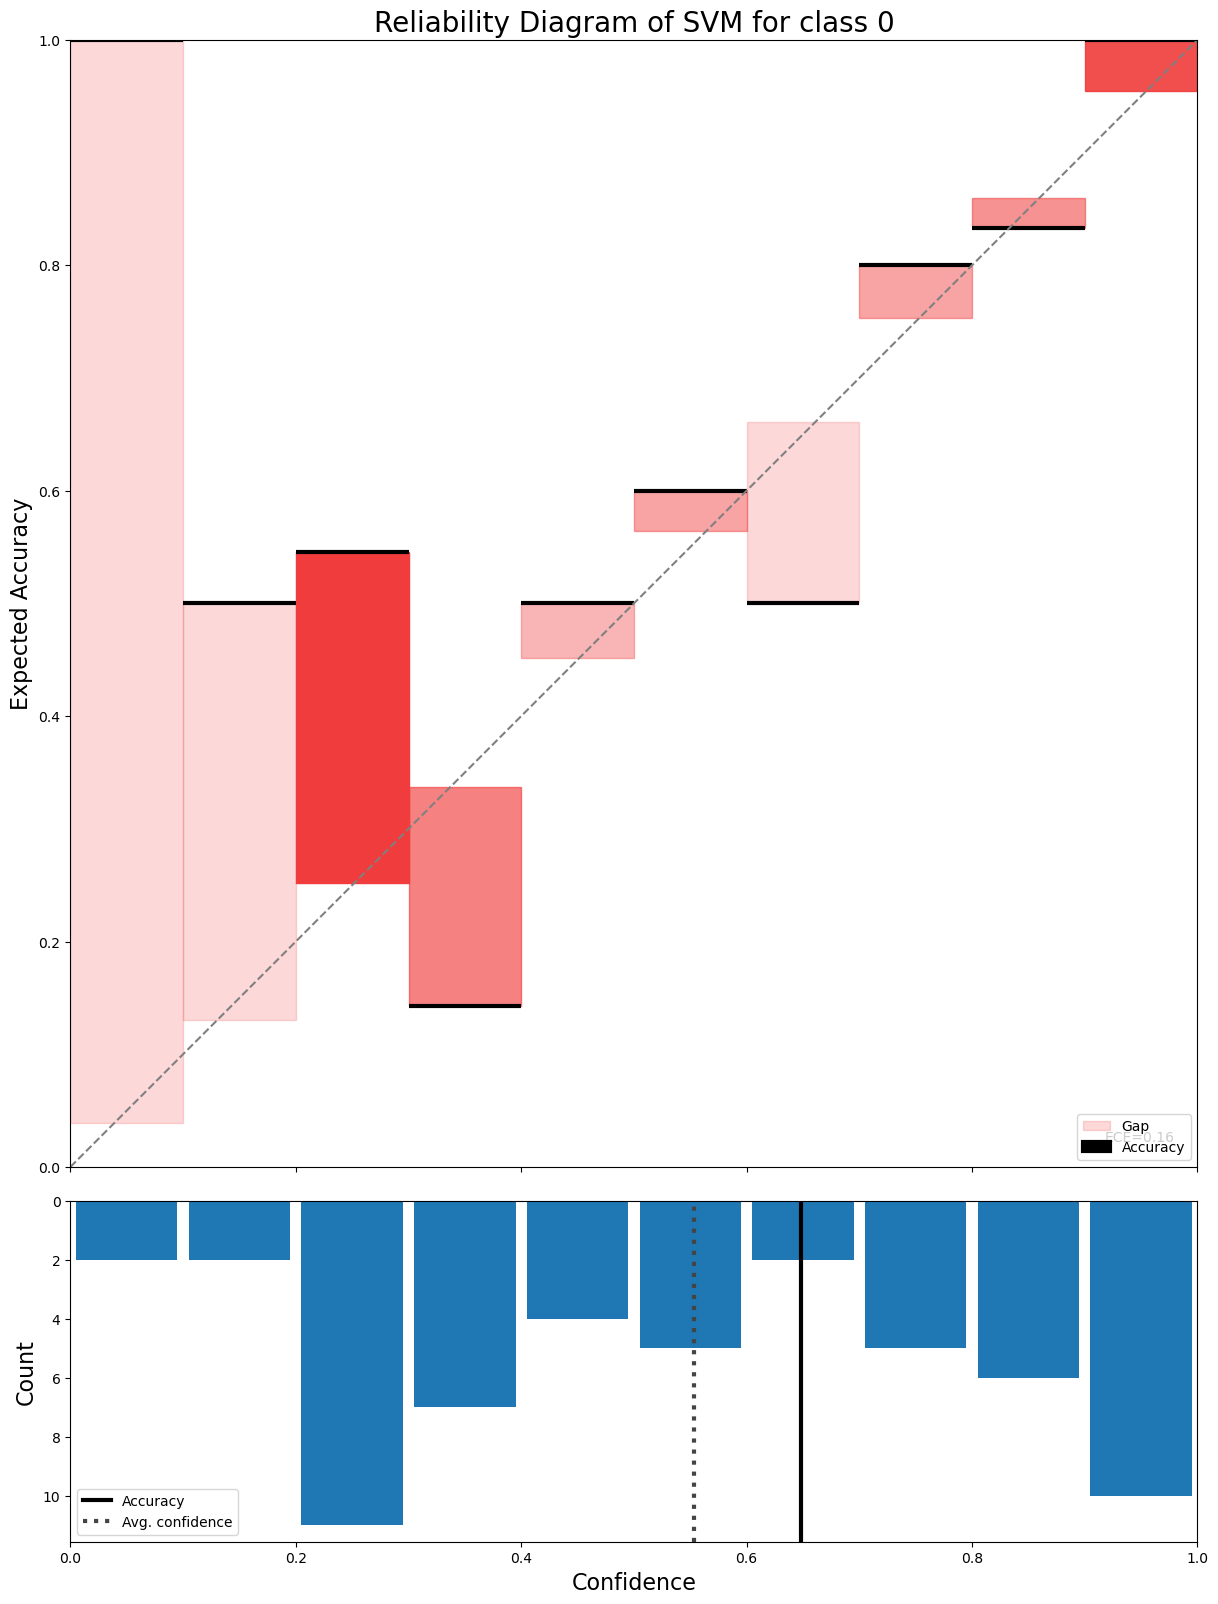

In [109]:
fig = reliability_diagram(y_test, y_hat, y_probs_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
#fig.savefig("Reliability Diagram of SVM for class 0.jpg", bbox_inches='tight')

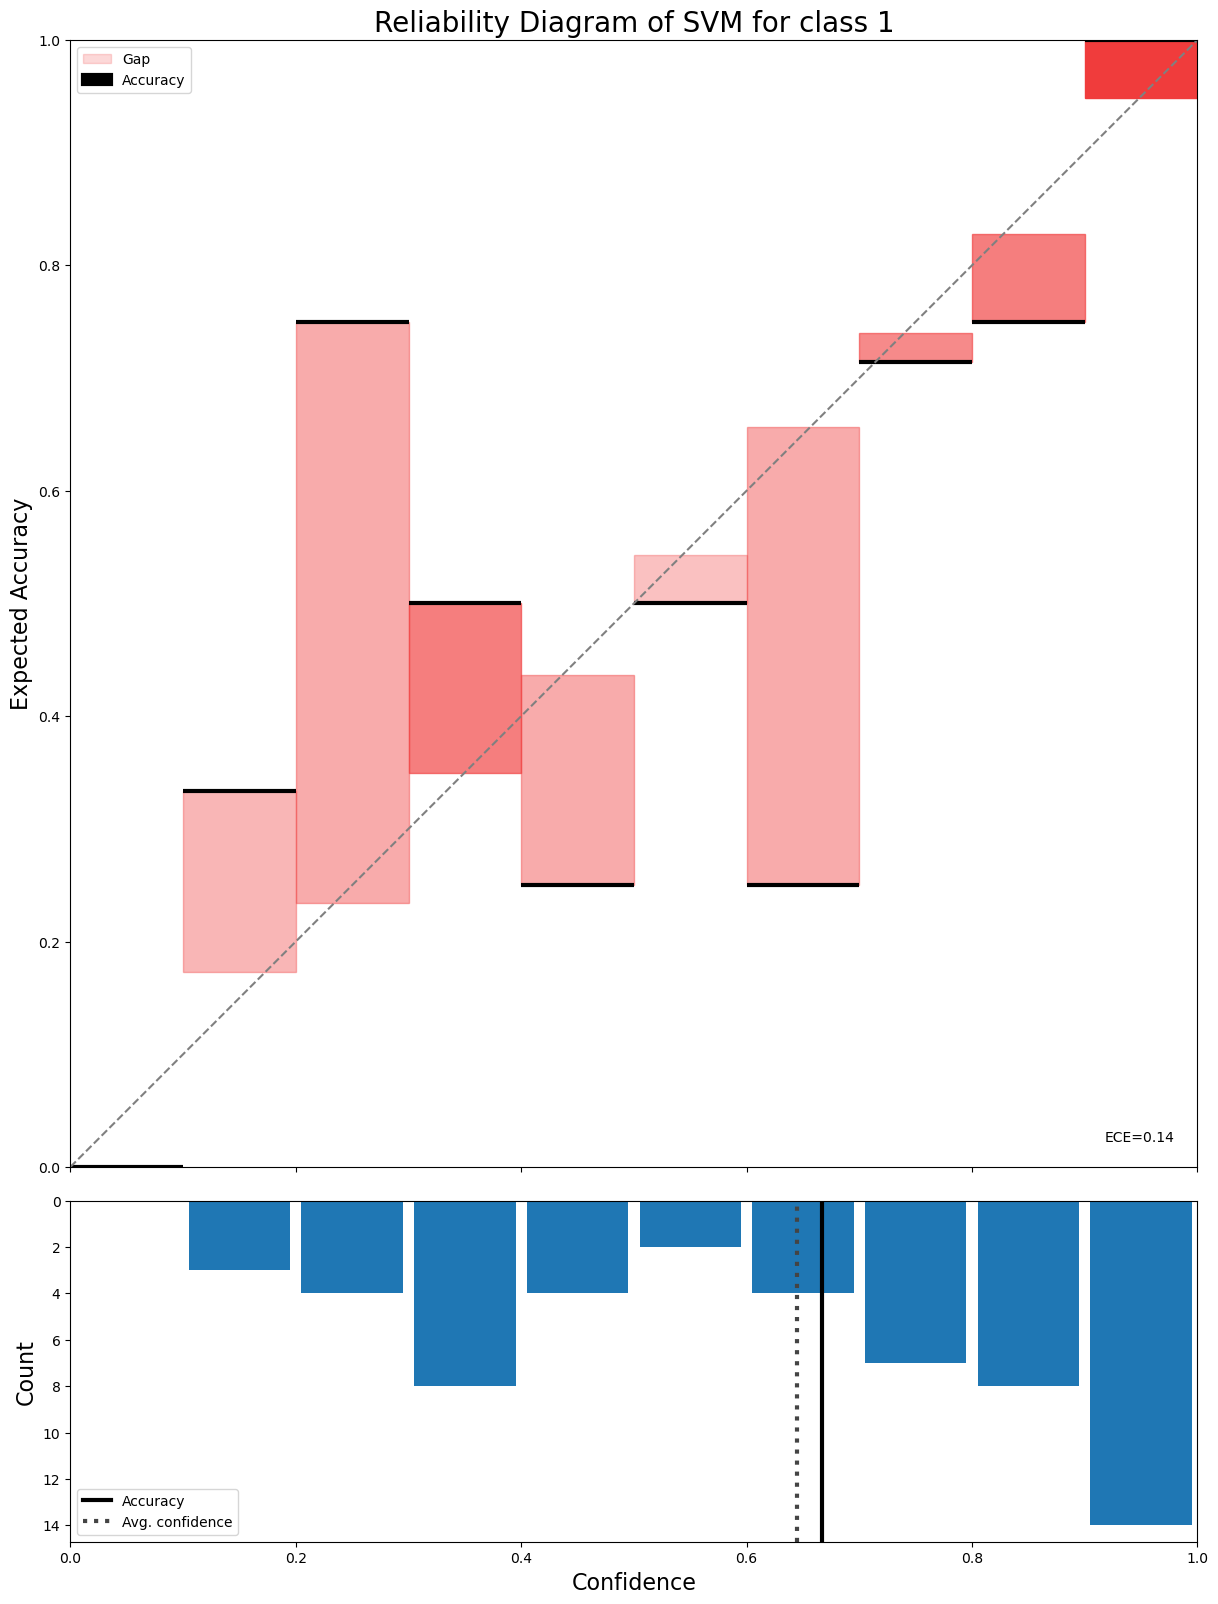

In [110]:
fig = reliability_diagram(y_test, y_hat, y_probs_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of Logistic Regression for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
#fig.savefig("Reliability Diagram of SVM for class 1.jpg", bbox_inches='tight')

../support_functions/reliability_diagrams.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


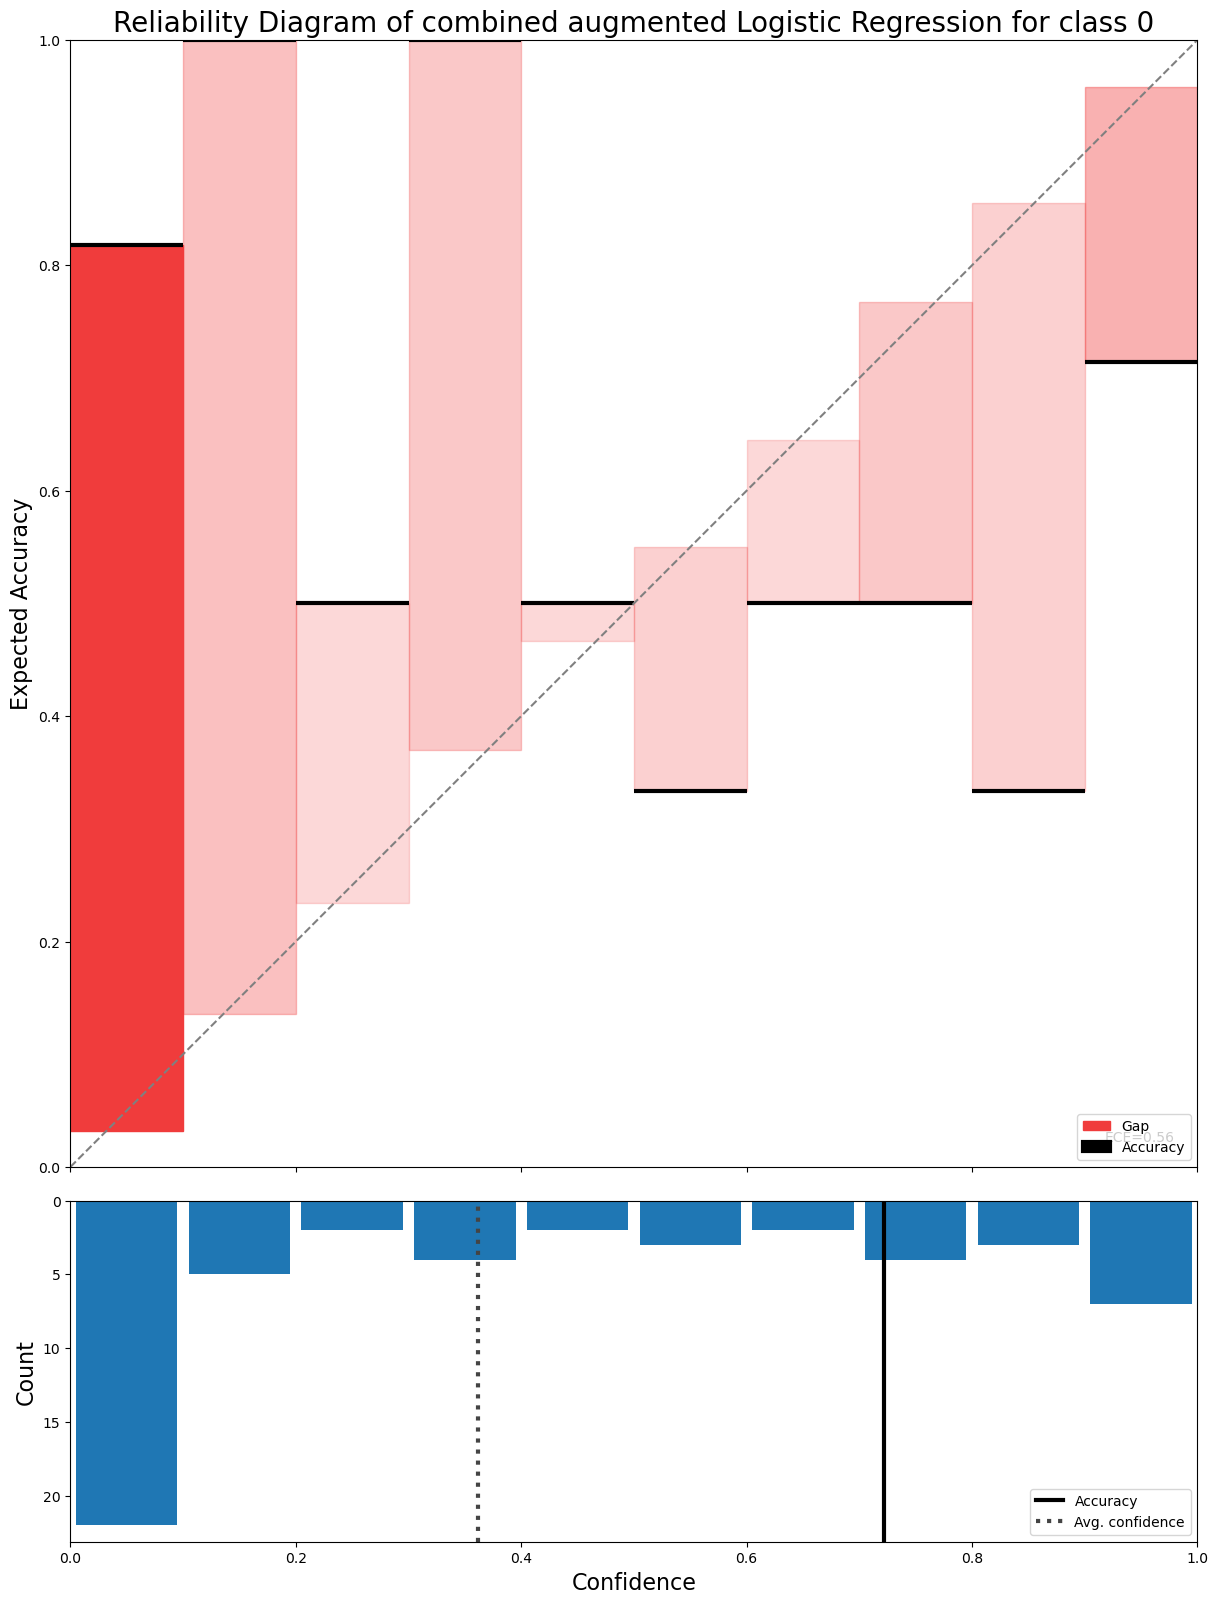

In [566]:
fig = reliability_diagram(y_test, y_hat_aug_combined, y_probs_combined_aug_0, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of combined augmented Logistic Regression for class 0", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of combined augmented Logistic Regression for class 0.jpg", bbox_inches='tight')

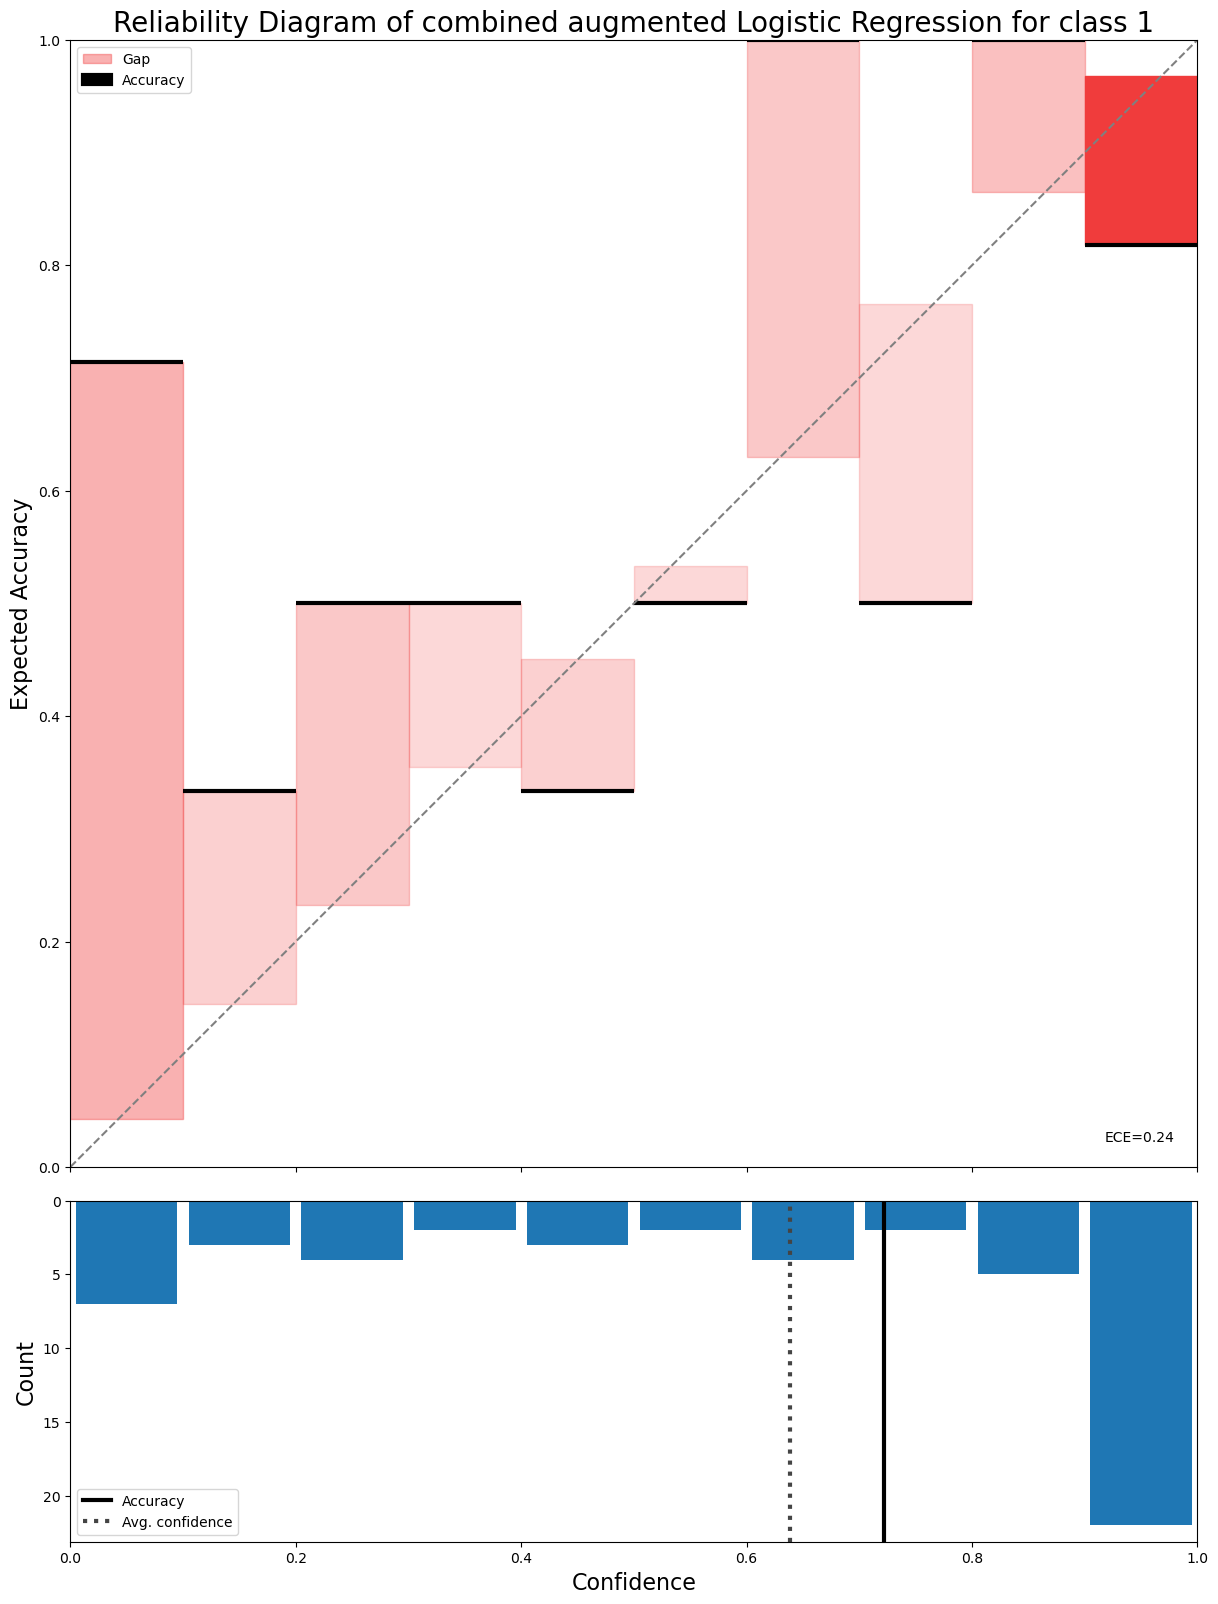

In [567]:
fig = reliability_diagram(y_test, y_hat_aug_combined, y_probs_combined_aug_1, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title="Reliability Diagram of combined augmented Logistic Regression for class 1", figsize=(12, 6), dpi=100, 
                          return_fig=True)
fig.savefig("Reliability Diagram of combined augmented Logistic Regression for class 1.jpg", bbox_inches='tight')